#Load libraries

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
import seaborn as sns
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pickle
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# hide this cell if not running on google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load train test data

In [2]:
data = None
path = '/content/drive/MyDrive/Colab Notebooks/data'

with open(path+'/classification_train_test_data.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data.keys())
#print(type(data['labels']))
train_data = tf.data.Dataset.from_tensor_slices((data['train']['features_rgb'],data['train']['labels']))
test_data = tf.data.Dataset.from_tensor_slices((data['test']['features_rgb'],data['test']['labels']))

dict_keys(['train', 'test', 'class_labels'])


# Create train and validation set

In [3]:
# defining some hyperparameters
TRAIN_LENGTH = int(0.7 * len(train_data))
BUFFER_SIZE = 1000
BATCH_SIZE = 64
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# Split the dataset into training and testing subsets
train_dataset = train_data.take(TRAIN_LENGTH)
val_dataset =  train_data.skip(TRAIN_LENGTH)


train_ds = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(100).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#train_dataset = train_datase
test_ds = test_data.shuffle(BUFFER_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(100).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Load inceptionV3 with imagenet weights

In [4]:
import tensorflow
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras import regularizers

input_shape = (224, 224, 3)

num_labels = 8

base_model = InceptionV3(include_top=False, input_shape=(224, 224, 3),pooling = 'avg', weights = 'imagenet')
model_inv3 = Sequential()
model_inv3.add(base_model)
model_inv3.add(Dropout(0.5))
model_inv3.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model_inv3.add(Dropout(0.5))
model_inv3.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = False

#for layer in base_model.layers[-30:]:
 #   layer.trainable = True

87910968/87910968 [==============================] - 5s 0us/step


# Model Summary

In [5]:
model_inv3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 22066088 (84.18 MB)
Trainable params: 263304 (1.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


# Model Architecture

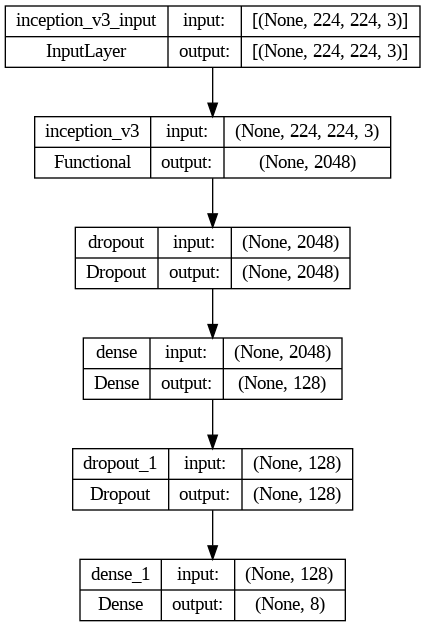

In [6]:
tf.keras.utils.plot_model(model_inv3, show_shapes=True,to_file='./InceptionV3.png')

# Compile Model

In [7]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model_inv3.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

#Compute class weights

In [8]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1,2,3,4,5,6,7],y=np.array(data['train']['labels']).argmax(axis=1))
class_weight_dict = {class_index: weight for class_index, weight in enumerate(class_weights)}

# checkpoint callback for saving the model

In [9]:
checkpoint=  ModelCheckpoint(filepath = path+'/inceptionV3.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=2, min_delta=0.001)
csv_logger = CSVLogger(path+'/InceptionV3_training_ISIC_2019.csv')

# Model Training

In [10]:
history = model_inv3.fit(train_ds,
                    steps_per_epoch=(len(train_ds)/10),
                    epochs=50,
                    verbose=2,
                    validation_data=val_ds,validation_steps=len(test_ds)/BATCH_SIZE,callbacks=[checkpoint,Earlystop,csv_logger],class_weight=class_weight_dict)

Epoch 1/50
530/530 - 93s - loss: 4.5510 - accuracy: 0.3148 - val_loss: 2.5203 - val_accuracy: 0.3980 - 93s/epoch - 175ms/step
Epoch 2/50
530/530 - 70s - loss: 1.9869 - accuracy: 0.4246 - val_loss: 1.8026 - val_accuracy: 0.4745 - 70s/epoch - 133ms/step
Epoch 3/50
530/530 - 68s - loss: 1.8137 - accuracy: 0.4311 - val_loss: 1.8739 - val_accuracy: 0.4416 - 68s/epoch - 129ms/step
Epoch 4/50
530/530 - 70s - loss: 1.8146 - accuracy: 0.4285 - val_loss: 1.7298 - val_accuracy: 0.4942 - 70s/epoch - 132ms/step
Epoch 5/50
530/530 - 68s - loss: 1.8313 - accuracy: 0.4248 - val_loss: 1.8134 - val_accuracy: 0.4507 - 68s/epoch - 129ms/step
Epoch 6/50
530/530 - 68s - loss: 1.8304 - accuracy: 0.4190 - val_loss: 1.8002 - val_accuracy: 0.4531 - 68s/epoch - 129ms/step


#Model evaluation

In [11]:
df = pd.read_csv(path+'/InceptionV3_training_ISIC_2019.csv')
df.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.314797,4.551001,0.398026,2.520345
1,1,0.424553,1.986884,0.474507,1.802574
2,2,0.431116,1.813694,0.441612,1.873909
3,3,0.428461,1.814633,0.494243,1.729805
4,4,0.424791,1.831253,0.450658,1.813430


In [12]:
df['accuracy'] = df['accuracy']*100
df['loss'] = df['loss']*100
df['val_accuracy'] = df['val_accuracy']*100
df['val_loss'] = df['val_loss']*100


# Accuracy

<Axes: >

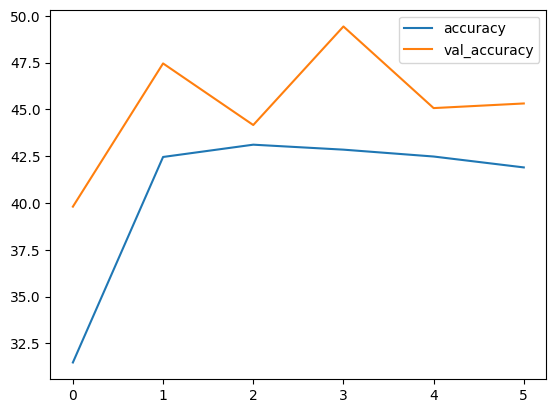

In [13]:
df.loc[:,['accuracy','val_accuracy']].plot()

#Loss

<Axes: >

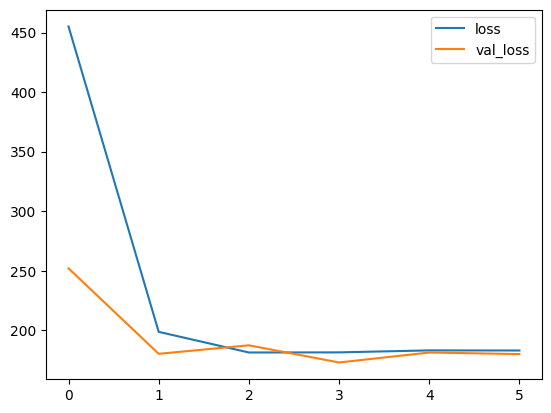

In [14]:
df.loc[:,['loss','val_loss']].plot()

# Calculate ROC and AUC

In [15]:
from functools import reduce

res_true,res_pred,org_true,org_pred=[],[],[],[]
targetnames = data['class_labels']
for i,j in test_ds:
    predictions = model_inv3.predict(tf.expand_dims(i, axis=0), steps=len(test_ds)/BATCH_SIZE, verbose=1)
    #geting predictions on test dataset
    y_pred = np.argmax(predictions, axis=1)


    y_true = np.argmax(j.numpy(),axis=0)#[k for i,k in test_data]
    #y_true = [np.argmax(k,axis=1) for k in y_true][0]
    print(predictions[0])
    #getting the predicted labels per image
    y_prob=predictions[0]
    #print(y_pred)

    res_pred.append(predictions[0])
    res_true.append(y_true)

 1/18 [>.............................] - ETA: 39s

18/18 [==============================] - 3s 18ms/step
[0.29840988 0.0710717  0.07383427 0.04108337 0.31482372 0.05501553
 0.01254333 0.13321812]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07695546 0.02816112 0.41138136 0.03203734 0.1281463  0.09295832
 0.03111242 0.19924767]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23832792 0.0562021  0.1755139  0.02431524 0.2135897  0.03450172
 0.14242345 0.11512598]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02872542 0.01640367 0.10692209 0.26685658 0.06366088 0.1628862
 0.01539216 0.33915296]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01545817 0.01096986 0.08376875 0.15827805 0.03656257 0.3157662
 0.01587569 0.36332068]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05744309 0.01714367 0.18818748 0.09478898 0.15899593 0.1556194
 0.00852836 0.3192931 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03442503 0.02949408 0.08171835 0.14790635 0.09242427 0.44461778
 0.02181718 0.14759694]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06017344 0.05107783 0.14315742 0.05111323 0.0879641  0.2099899
 0.32518208 0.07134195]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05134628 0.01726659 0.61682075 0.03285768 0.10442315 0.04349206
 0.04725873 0.08653472]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3590007  0.03007581 0.0350127  0.0159661  0.43963996 0.01465943
 0.00187924 0.10376609]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28345445 0.33491346 0.05613117 0.05002879 0.09718802 0.06358781
 0.07081471 0.04388159]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21554826 0.5240399  0.02598108 0.02272057 0.06513217 0.09837657
 0.01542483 0.03277663]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01639784 0.00810467 0.14030057 0.2551011  0.0315158  0.08561205
 0.00973476 0.45323315]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2670123  0.15521653 0.04742437 0.17412488 0.21483383 0.05710381
 0.00620864 0.07807563]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.412809   0.19364926 0.0633802  0.01211397 0.15505295 0.01018158
 0.13091344 0.02189956]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06885312 0.04693945 0.13585263 0.13659176 0.11155503 0.23652215
 0.03164954 0.23203626]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05040217 0.01656955 0.20075245 0.1528938  0.14179002 0.12137643
 0.01558767 0.30062792]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10762464 0.06516252 0.11464512 0.19271065 0.26000428 0.10530615
 0.03355314 0.12099352]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02088068 0.0109178  0.19333369 0.33255374 0.02230878 0.07579418
 0.01202006 0.33219108]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01360235 0.02240751 0.10147727 0.3162218  0.03124131 0.33389893
 0.04196595 0.13918486]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00376898 0.00170371 0.10091636 0.25949898 0.00619295 0.04114877
 0.00697474 0.57979554]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02633951 0.02616291 0.22978099 0.27067164 0.02971022 0.13076694
 0.01945593 0.2671119 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22120127 0.10209855 0.12455763 0.07408991 0.21683712 0.09590653
 0.01447007 0.1508389 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04684306 0.01536627 0.10940196 0.15418649 0.03864584 0.03055676
 0.01297937 0.5920203 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09503097 0.03829428 0.37306446 0.05984254 0.14860703 0.06045882
 0.05263795 0.17206402]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04472031 0.05872703 0.03010183 0.00568098 0.03679477 0.02477441
 0.7928756  0.00632505]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14331025 0.05091168 0.30284202 0.03431673 0.17362739 0.05484739
 0.07925446 0.16089001]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13459599 0.0285821  0.18005387 0.06947395 0.24173716 0.09691838
 0.03316651 0.21547201]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05495232 0.01733153 0.30616975 0.21459545 0.09498094 0.05126249
 0.01253538 0.24817221]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20986003 0.06483669 0.09992584 0.08290138 0.25334984 0.08169096
 0.01383446 0.19360082]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3261429  0.13227688 0.03470967 0.04526165 0.39207113 0.02543918
 0.00630052 0.03779804]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15919314 0.31671014 0.13802351 0.02518239 0.1240168  0.1319911
 0.06023154 0.04465134]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2524975  0.07132472 0.11458584 0.06732955 0.27608666 0.04103185
 0.02194766 0.1551962 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11589133 0.02107165 0.33610377 0.1207436  0.15717617 0.0211689
 0.00808025 0.21976434]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02465781 0.02768006 0.05145964 0.7654047  0.0175686  0.02856435
 0.00227104 0.08239383]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10332669 0.05177061 0.2527518  0.14757234 0.15235181 0.09277014
 0.017178   0.18227863]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.37113455 0.42288402 0.00808838 0.02460429 0.12977108 0.02138461
 0.00479975 0.01733331]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2161612  0.24110292 0.16146858 0.01981743 0.1300486  0.08587763
 0.08685435 0.05866929]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.42706653 0.11487422 0.06422529 0.01145881 0.26156974 0.01133392
 0.0702399  0.03923158]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19324054 0.10200602 0.11618788 0.0577069  0.20777749 0.09924237
 0.03175152 0.19208731]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01986433 0.01292694 0.12133079 0.28917876 0.03065019 0.09096567
 0.02351737 0.41156596]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03387735 0.03521299 0.13981621 0.24924791 0.04682203 0.23795214
 0.01964408 0.23742737]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2966672  0.13211924 0.0635849  0.02845106 0.32935533 0.07536218
 0.01571214 0.0587479 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17320545 0.2584115  0.18903574 0.02301031 0.1497509  0.0989525
 0.06604774 0.0415858 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01222339 0.00657794 0.33026996 0.16359843 0.02288014 0.06987397
 0.06227962 0.33229652]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2566891  0.19024712 0.10866792 0.03404579 0.1356533  0.09077386
 0.09848383 0.08543905]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23989487 0.03370076 0.22282223 0.0271084  0.23944907 0.02330334
 0.00755577 0.2061656 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06916641 0.00994451 0.5813751  0.03300961 0.13260323 0.02805817
 0.00883594 0.13700701]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0453231  0.01010375 0.20844251 0.21794108 0.13238995 0.04161435
 0.00458286 0.33960238]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16070436 0.13922612 0.09124096 0.05268783 0.18776312 0.10345464
 0.20960386 0.05531915]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10540717 0.0770761  0.09203474 0.19124104 0.16819787 0.18698877
 0.02065189 0.15840243]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22924404 0.28550726 0.04878112 0.11343235 0.138705   0.10469446
 0.0244642  0.05517154]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07763118 0.03267241 0.26878095 0.09867347 0.14349695 0.14641462
 0.04767872 0.18465167]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.31126875 0.15896799 0.20373704 0.01604104 0.18898886 0.02215089
 0.02387753 0.0749679 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16786599 0.07120765 0.06558843 0.06179094 0.31538808 0.16198805
 0.02811375 0.12805714]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0140176  0.01087038 0.17737368 0.20866139 0.01511926 0.11888475
 0.04486354 0.4102094 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05045632 0.02170666 0.12944508 0.1523254  0.10509308 0.16326217
 0.05042889 0.32728246]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20207807 0.13942836 0.05151194 0.0874826  0.3038253  0.10072424
 0.02201483 0.09293465]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07765836 0.03567289 0.19406816 0.11913577 0.22010499 0.16565219
 0.02642352 0.1612842 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09533542 0.06004587 0.18511161 0.12333047 0.22205004 0.15014166
 0.03745863 0.12652628]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23435564 0.15198478 0.0392691  0.03579955 0.33772108 0.10564289
 0.00911396 0.08611298]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02134177 0.01638324 0.2343704  0.21171239 0.02646971 0.11016279
 0.05443575 0.32512394]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4743511  0.13521977 0.02199537 0.02581368 0.29195315 0.01343281
 0.00296445 0.0342697 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18934312 0.47317168 0.05622759 0.02935376 0.11327093 0.07578377
 0.04283401 0.02001516]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02521669 0.01467576 0.15978305 0.11371519 0.05208763 0.15003417
 0.1430708  0.34141672]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15104507 0.05874966 0.13998583 0.0885165  0.18126704 0.10753636
 0.00907934 0.2638202 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22889954 0.09296646 0.08556318 0.14671206 0.3118383  0.05304543
 0.00668109 0.07429392]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02754463 0.02247388 0.14740467 0.18380286 0.09764285 0.36656204
 0.01501258 0.13955653]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.36081424 0.08126852 0.02635168 0.06642926 0.40100104 0.01709058
 0.00215563 0.04488908]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21853033 0.0991612  0.06770375 0.10783559 0.22361726 0.07282303
 0.0056509  0.20467794]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4891721  0.13702281 0.03691891 0.03028749 0.23007745 0.01716091
 0.00376512 0.05559519]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04235876 0.03942177 0.13364305 0.03370857 0.05613228 0.27884534
 0.32215294 0.09373735]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03363565 0.01832041 0.22455558 0.13950759 0.04014274 0.15726273
 0.14323543 0.24333985]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00999834 0.00461841 0.10237347 0.33677685 0.01515389 0.07174945
 0.00820423 0.4511253 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03291435 0.0350894  0.11721154 0.25051633 0.06304761 0.31825185
 0.05140886 0.13156006]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1823482  0.0784106  0.3257418  0.02682843 0.18517974 0.0341878
 0.0938553  0.07344819]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12395681 0.08846162 0.22924638 0.02135096 0.13600777 0.10159317
 0.23595347 0.06342984]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16766892 0.04997266 0.32895413 0.02737449 0.15209311 0.05088563
 0.13251607 0.09053493]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2658347  0.06278642 0.03629563 0.05090384 0.4470289  0.03420517
 0.00853732 0.0944081 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10137313 0.05317602 0.12774833 0.09605525 0.14819679 0.19493382
 0.06098185 0.21753488]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01198029 0.00391374 0.15422282 0.18510719 0.01700441 0.03249533
 0.02101519 0.574261  ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.41248652 0.09834057 0.02395762 0.03509189 0.34914976 0.03314318
 0.00268722 0.04514324]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.29952806 0.06914143 0.14007463 0.04300694 0.28088698 0.02069973
 0.02437767 0.12228455]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04220447 0.02000885 0.11954404 0.18196926 0.09260201 0.18783498
 0.01308979 0.34274665]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05107976 0.02558528 0.1612691  0.20263146 0.06250047 0.09522515
 0.09200595 0.3097028 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00507213 0.00868507 0.10523031 0.5246319  0.00613612 0.1229373
 0.01166944 0.21563777]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01821304 0.01390648 0.16011706 0.20534466 0.03566217 0.18378757
 0.01120752 0.37176144]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.36361456 0.07062813 0.09348151 0.02502302 0.3081572  0.02292569
 0.02389984 0.09227008]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20328258 0.05764588 0.18156885 0.03070699 0.22689629 0.0554698
 0.07286414 0.17156558]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28476232 0.2312241  0.07891163 0.02121175 0.19736788 0.05222411
 0.0837686  0.05052968]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.36541808 0.49373117 0.01009941 0.01800363 0.06922738 0.0166274
 0.00318671 0.02370629]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04490484 0.03669759 0.11099767 0.1606835  0.03861834 0.19635107
 0.11896958 0.29277742]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18042676 0.17972021 0.03657551 0.00988185 0.07479945 0.02174321
 0.48353997 0.01331299]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08864911 0.02581821 0.36471376 0.19640164 0.13183083 0.02398034
 0.00919755 0.15940855]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14551431 0.0677373  0.08886573 0.05157372 0.3182381  0.16044602
 0.0622275  0.10539733]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10580014 0.03456979 0.11813095 0.16740838 0.19012138 0.10861445
 0.00999832 0.26535654]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02562162 0.02118265 0.09596807 0.03746786 0.02564517 0.11198947
 0.59368485 0.08844032]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.37359223 0.10112353 0.04674883 0.04856099 0.28733918 0.03294662
 0.00529983 0.10438877]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.028843   0.03867291 0.2341153  0.28795427 0.04757433 0.14295343
 0.02203829 0.19784853]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05099559 0.04484897 0.08850046 0.03995425 0.08340506 0.251007
 0.36310947 0.07817929]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.6112584  0.15400094 0.02805236 0.01351742 0.11540975 0.00790268
 0.00618883 0.06366967]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21198332 0.2553903  0.07172474 0.00968584 0.09873582 0.04744947
 0.28053662 0.02449388]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06362467 0.0491326  0.17168671 0.07576124 0.08124898 0.19824602
 0.23626003 0.12403982]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03868476 0.00459716 0.5315507  0.02572914 0.07902484 0.01420285
 0.01578121 0.29042926]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05804428 0.02464985 0.20730151 0.21499063 0.11443973 0.06947358
 0.01660768 0.2944927 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4724706  0.31086406 0.02926988 0.01729329 0.12063829 0.01279616
 0.00672656 0.02994121]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3001425  0.09271074 0.07100988 0.02163129 0.22533974 0.04537723
 0.19520175 0.04858688]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.26323122 0.56274945 0.01527916 0.01256075 0.07072479 0.01922112
 0.0436619  0.01257162]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11023174 0.05587304 0.16763401 0.05945925 0.09412311 0.16769698
 0.23021848 0.11476333]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13118567 0.0456518  0.08123171 0.09135877 0.29269576 0.072688
 0.00503197 0.2801563 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19960576 0.14117761 0.06473586 0.04906137 0.16529721 0.17510818
 0.13269822 0.07231581]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05270772 0.03291727 0.29425028 0.07222574 0.08151397 0.1610455
 0.15554784 0.14979167]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.46997172 0.08307285 0.05540869 0.01858553 0.21987112 0.02600507
 0.02169153 0.10539354]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06251181 0.03824873 0.11430991 0.4588504  0.09926964 0.07110826
 0.01321233 0.14248891]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19005474 0.05400029 0.18583699 0.08395196 0.21909368 0.04912341
 0.0097617  0.20817724]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05932725 0.04291442 0.15764865 0.24630278 0.08297648 0.12723605
 0.08508376 0.19851048]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01543067 0.01122923 0.08466408 0.68895596 0.01897967 0.04628369
 0.00274711 0.13170965]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0709089  0.01219504 0.11039083 0.13788806 0.3287141  0.05726233
 0.00445531 0.27818543]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23106766 0.11876593 0.10053455 0.09641304 0.31611714 0.05692319
 0.01768165 0.06249689]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07575944 0.06882975 0.1477842  0.14747892 0.10585903 0.21761617
 0.09478764 0.14188485]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07201041 0.0278662  0.19856946 0.15275425 0.10815882 0.07687999
 0.00962458 0.35413632]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01872648 0.0164899  0.10802629 0.13725184 0.03474636 0.3610582
 0.04558396 0.27811694]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03182838 0.02517651 0.13783033 0.1481574  0.03898361 0.22812222
 0.14017208 0.24972945]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01718997 0.02650333 0.0770068  0.15088919 0.03030646 0.50691706
 0.0204695  0.17071772]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01076799 0.00530088 0.10253449 0.2511285  0.02382694 0.06419608
 0.0067498  0.53549534]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03525755 0.02328053 0.06475925 0.01322587 0.02463232 0.05458698
 0.7542699  0.02998763]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03924197 0.1046029  0.12913686 0.03362353 0.03960473 0.3315888
 0.25336534 0.06883589]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09603741 0.02484281 0.32999876 0.04922436 0.14947923 0.03173174
 0.17797935 0.14070635]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4221596  0.11121354 0.0623438  0.01652293 0.26847586 0.01454123
 0.04960471 0.05513833]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16837421 0.03187402 0.22405286 0.07800353 0.30937433 0.02515943
 0.01000455 0.15315707]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3586544  0.392316   0.02507851 0.01773224 0.14230262 0.02567243
 0.01361624 0.02462761]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2755653  0.2843692  0.05328943 0.04161645 0.13263927 0.10681116
 0.03738841 0.06832071]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04724466 0.01883881 0.17372847 0.13288295 0.1151403  0.17048272
 0.03657168 0.30511042]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13818555 0.03687365 0.13134323 0.21193275 0.18518113 0.05856171
 0.0026399  0.23528203]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04320749 0.02647918 0.06886213 0.65944344 0.02013306 0.02394563
 0.00307212 0.15485698]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.56298405 0.17884277 0.02549033 0.01293603 0.16396655 0.00864649
 0.00913976 0.03799401]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09736436 0.16194339 0.24533999 0.0661715  0.11654203 0.20268834
 0.05305273 0.05689773]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.32188705 0.1442247  0.12841457 0.01493969 0.26599443 0.02519906
 0.01458211 0.0847584 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1530808  0.02237112 0.09107035 0.06583836 0.34710148 0.06438134
 0.00645424 0.24970233]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10254467 0.03679282 0.130479   0.22852439 0.25955808 0.06463305
 0.00881104 0.16865692]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01795366 0.00538375 0.15127741 0.13885273 0.03222559 0.07221712
 0.01742396 0.5646658 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05558278 0.0573634  0.08255296 0.00519137 0.04422947 0.02546116
 0.72210795 0.00751087]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12495262 0.01442871 0.13232698 0.08695791 0.36657873 0.03483935
 0.00304325 0.23687245]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07211961 0.02542693 0.31319663 0.13276218 0.17311    0.10057857
 0.01591176 0.16689432]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11005609 0.07225867 0.0363523  0.00539288 0.05150601 0.01752461
 0.69647753 0.01043185]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.32387948 0.06352746 0.07312533 0.03881866 0.29023668 0.04491427
 0.01294124 0.15255684]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03963036 0.01293878 0.13402773 0.17259742 0.05760541 0.08488131
 0.02821939 0.47009957]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13665268 0.14410283 0.3142845  0.01764637 0.14595152 0.08852938
 0.09737283 0.0554598 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.30090582 0.1279119  0.08458303 0.04133547 0.23785345 0.0678461
 0.03063421 0.10893005]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2838255  0.1021958  0.03259354 0.05141814 0.45160034 0.0269191
 0.00918891 0.0422587 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08240329 0.0174897  0.21285005 0.07438341 0.2132798  0.0983495
 0.02433865 0.27690563]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16584851 0.69042695 0.00444618 0.00463473 0.06082502 0.00378184
 0.06870832 0.00132849]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19163787 0.2822451  0.08096299 0.06500755 0.11208168 0.10197524
 0.02035545 0.14573412]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15071432 0.06930748 0.09306584 0.0177701  0.14673595 0.04175987
 0.43828115 0.04236533]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22334142 0.11949119 0.17221649 0.0362462  0.19114183 0.06931916
 0.1105714  0.07767224]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.29607025 0.456083   0.02250071 0.01120691 0.06587982 0.03095581
 0.10007998 0.01722345]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10601116 0.01738803 0.19442582 0.18847808 0.21917571 0.03825769
 0.00305529 0.2332082 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16218624 0.09616558 0.21079601 0.03823137 0.19079648 0.12843691
 0.02022161 0.15316582]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02345299 0.0271395  0.23962618 0.06589195 0.02882623 0.21995348
 0.26236862 0.13274106]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05071595 0.09210438 0.15144372 0.06684556 0.05383796 0.28041545
 0.21241064 0.09222636]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02383072 0.02841519 0.12018836 0.41842902 0.02439566 0.18094194
 0.02242279 0.18137625]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05692583 0.02727762 0.1866225  0.01891383 0.06697287 0.13088901
 0.43591225 0.0764861 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09897951 0.05967222 0.24008548 0.14295234 0.14568621 0.12533198
 0.06621496 0.12107722]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15151918 0.07092862 0.11911082 0.15867412 0.2704479  0.09048746
 0.02415246 0.11467949]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28870612 0.10653894 0.04082991 0.0689311  0.3317534  0.07587694
 0.00987666 0.07748696]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07460768 0.0155308  0.3961027  0.05260916 0.18078245 0.07323429
 0.02550994 0.181623  ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1485142  0.06818622 0.10434865 0.0533784  0.24870645 0.17235346
 0.02693033 0.17758232]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.39523938 0.17897151 0.09824002 0.0150603  0.21602856 0.01400287
 0.02980324 0.05265417]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05960357 0.04153056 0.08411177 0.3069318  0.07336927 0.18600774
 0.0117432  0.23670213]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08375841 0.02005495 0.5047871  0.02067106 0.14170253 0.04081072
 0.04904    0.13917528]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04908545 0.05337073 0.11428382 0.19759595 0.082961   0.257409
 0.05628593 0.18900819]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00391434 0.0016604  0.08729754 0.30029157 0.00426476 0.05511933
 0.00562933 0.5418228 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09797303 0.09056626 0.10658717 0.13352123 0.14570405 0.22894567
 0.03103991 0.16566266]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06307349 0.02438311 0.1251419  0.19643989 0.10789479 0.12116068
 0.0113011  0.35060507]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00406105 0.00118283 0.08935259 0.16217586 0.00720273 0.02832056
 0.00424376 0.70346063]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16281302 0.13234694 0.10916228 0.06542741 0.1423962  0.17939866
 0.06832368 0.14013177]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20680256 0.04283459 0.08837093 0.05097941 0.3245746  0.08804083
 0.01004792 0.18834923]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17352286 0.04461139 0.16666871 0.1044585  0.31956306 0.03172651
 0.00572013 0.1537289 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.5657119  0.2267884  0.00575856 0.01069568 0.16970982 0.00357114
 0.00120057 0.01656388]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02466704 0.06470354 0.07848362 0.04188342 0.01737973 0.12113661
 0.6249544  0.02679159]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10512543 0.12478566 0.28079593 0.04857634 0.13920762 0.11701998
 0.11600323 0.06848583]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00582732 0.00281129 0.11113736 0.25551564 0.0070485  0.04715135
 0.01065624 0.55985236]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3179902  0.4116929  0.02938697 0.01951264 0.07275879 0.06622396
 0.02032602 0.06210857]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[5.0489516e-03 8.7211896e-03 2.8198289e-03 2.6220942e-04 2.8313850e-03
 1.8567952e-03 9.7820115e-01 2.5842999e-04]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04905847 0.03754224 0.11641549 0.04831766 0.07385828 0.40267697
 0.143784   0.12834688]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14108044 0.026855   0.19233216 0.05458803 0.23410827 0.06084154
 0.00965257 0.28054193]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.26309723 0.5227535  0.02151149 0.0289571  0.07579072 0.04996733
 0.01138827 0.02653438]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15017083 0.71600896 0.00528785 0.00447626 0.07337555 0.00633057
 0.04253921 0.00181077]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.31887662 0.06256286 0.07066567 0.03952225 0.34248033 0.04282052
 0.00913952 0.1139322 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01316097 0.01029547 0.16103162 0.19300807 0.01562651 0.17294933
 0.04669322 0.38723478]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4082237  0.51222366 0.00791197 0.00369104 0.04093631 0.00407252
 0.0119814  0.01095943]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.167401   0.07036071 0.12068523 0.09030312 0.20573652 0.15113078
 0.03091005 0.16347258]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02462201 0.01818811 0.11540566 0.05218413 0.06144631 0.45256346
 0.10778429 0.16780597]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.43118155 0.15654516 0.03400154 0.03344287 0.26283473 0.01696062
 0.00891034 0.05612311]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06469826 0.02891818 0.1310034  0.12430955 0.05632858 0.0814624
 0.03778729 0.47549233]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03653906 0.0488098  0.16492775 0.2370043  0.03865241 0.27145633
 0.06971665 0.13289367]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08954129 0.0463119  0.20464203 0.12183839 0.305364   0.10082778
 0.01325914 0.11821549]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12802204 0.033236   0.13399029 0.09258481 0.27627194 0.09493615
 0.0182295  0.22272925]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08813219 0.05883672 0.12124648 0.21609887 0.15897645 0.1933995
 0.02280368 0.14050607]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.32970086 0.1070478  0.05320053 0.06255604 0.23377514 0.06319934
 0.00639106 0.14412928]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02824203 0.0119286  0.12833808 0.322166   0.05948525 0.09135289
 0.01456726 0.3439199 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14383554 0.0434488  0.12039273 0.12054189 0.27589658 0.13245855
 0.0120138  0.15141205]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23356    0.12255309 0.10400192 0.10207717 0.31523013 0.03561935
 0.01166279 0.07529561]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01590008 0.00492416 0.07010561 0.27834165 0.0321792  0.09315894
 0.00330518 0.50208527]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0323792  0.02146964 0.4559546  0.20885016 0.04918959 0.04915221
 0.0206334  0.16237117]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01535797 0.0149997  0.0837057  0.62230265 0.01512386 0.07838877
 0.00438047 0.16574083]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08542956 0.05656449 0.27296826 0.19882628 0.14302368 0.1084175
 0.01504136 0.11972889]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14110884 0.6526313  0.01684257 0.02184974 0.0549431  0.07649335
 0.01794386 0.01818723]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07942574 0.03870812 0.16718595 0.14328696 0.1008417  0.10333259
 0.02713796 0.34008098]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20631811 0.07022837 0.23292838 0.04654777 0.20990898 0.03790892
 0.0853507  0.11080883]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21620154 0.21179676 0.07305209 0.06514099 0.15323362 0.12762599
 0.0112301  0.14171895]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25436243 0.21286471 0.08212432 0.07372164 0.19426171 0.094542
 0.02114373 0.06697948]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.26956016 0.04614485 0.09639506 0.03226488 0.31056044 0.04600594
 0.00584738 0.1932213 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05057993 0.0557716  0.11676902 0.03401612 0.05893234 0.2992829
 0.34441903 0.04022907]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.31889907 0.50197256 0.02217963 0.01267002 0.06389385 0.02227807
 0.03479047 0.0233164 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05695681 0.03657588 0.50304985 0.03109598 0.09626641 0.13837147
 0.06339878 0.07428481]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04485395 0.01057271 0.6123928  0.04711829 0.07470343 0.01479507
 0.01053439 0.18502934]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03818293 0.04827322 0.13791996 0.43110108 0.03740639 0.15608327
 0.01098481 0.14004835]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.27960426 0.06047393 0.03281357 0.03403728 0.5073509  0.0231996
 0.00583757 0.05668285]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2509099  0.19595835 0.0630923  0.02948262 0.16750754 0.14633577
 0.0578404  0.08887315]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28653586 0.06542503 0.08925965 0.05495334 0.20306434 0.03829073
 0.02244869 0.24002236]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20331892 0.03640676 0.17274426 0.0473977  0.24582113 0.04703506
 0.03545383 0.21182229]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07473688 0.11117517 0.10273693 0.24607424 0.05791252 0.2127109
 0.027602   0.1670514 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.43383342 0.09047119 0.01637034 0.03404178 0.37408072 0.01836911
 0.00240329 0.03043008]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08293903 0.06671275 0.09347476 0.12098707 0.06151854 0.13271934
 0.0108327  0.43081582]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14694244 0.10183366 0.0621326  0.0490215  0.3388732  0.13773948
 0.1111707  0.05228636]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.46247146 0.1477197  0.02306101 0.03659182 0.29461458 0.00741617
 0.0044551  0.02367014]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13008727 0.06707481 0.16336922 0.08396811 0.16564447 0.19189821
 0.01605525 0.1819026 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24081185 0.13840936 0.23461476 0.02892522 0.15270182 0.03972545
 0.08876828 0.07604326]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21529505 0.21479876 0.07552843 0.09353098 0.17238814 0.12496497
 0.02658946 0.07690424]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3165864  0.32123715 0.03053329 0.04601316 0.16878664 0.03523612
 0.00840973 0.07319758]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22258817 0.0259201  0.16370392 0.02503099 0.34992874 0.02598383
 0.03371615 0.1531281 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04500397 0.03547078 0.19122076 0.16248325 0.11377879 0.2946164
 0.0177769  0.13964915]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11546714 0.40416119 0.0845076  0.02811864 0.06943128 0.20194982
 0.05087517 0.04548911]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18794344 0.1815142  0.15689816 0.04790832 0.19198748 0.12005314
 0.02208554 0.09160966]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16012067 0.12074895 0.07425457 0.13096341 0.29603338 0.11055519
 0.03212529 0.07519847]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0895896  0.08163466 0.25045598 0.08323303 0.17641477 0.16036053
 0.06994836 0.08836309]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13877395 0.06683312 0.260595   0.02285139 0.16684002 0.06070613
 0.22212091 0.06127952]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01448483 0.00726163 0.12535103 0.16637158 0.02747148 0.1144113
 0.02033109 0.524317  ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25531265 0.27353573 0.06828813 0.06456882 0.20706724 0.05288843
 0.0115049  0.06683411]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22473058 0.122365   0.22017956 0.02207537 0.25013125 0.03599365
 0.05390451 0.07062011]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19804777 0.29123574 0.02865948 0.03519729 0.35877174 0.04846771
 0.01927572 0.02034452]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06099031 0.08942038 0.07176631 0.32592392 0.04413078 0.23233798
 0.01297341 0.16245687]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.29619747 0.46973413 0.02178073 0.02243121 0.10852704 0.03472966
 0.00998606 0.03661367]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13908122 0.0547435  0.08292498 0.12308057 0.22628526 0.13368641
 0.01077406 0.22942398]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09270901 0.05521199 0.17462005 0.09341661 0.13368863 0.10367198
 0.02512899 0.32155272]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16532928 0.2039434  0.04247963 0.03758829 0.2637087  0.17691758
 0.06270221 0.04733086]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11828233 0.65400374 0.02006845 0.0224178  0.03099701 0.10982227
 0.01652597 0.0278824 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15503745 0.04250014 0.10139159 0.06858025 0.2610584  0.09467217
 0.03665764 0.24010238]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06502672 0.02600336 0.15104605 0.16328666 0.14569531 0.17413053
 0.01701512 0.25779623]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15072191 0.08666565 0.05620984 0.09191316 0.33881068 0.17883565
 0.01616873 0.08067434]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01948754 0.00924192 0.16319643 0.24294195 0.04933448 0.08496924
 0.04320932 0.38761905]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19220194 0.04854768 0.18779564 0.1002793  0.2971044  0.03963181
 0.00870442 0.12573485]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1842328  0.03019239 0.02529355 0.02713634 0.5673048  0.07349423
 0.00354053 0.08880532]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25621232 0.22604512 0.12719473 0.01962926 0.14554729 0.06798106
 0.0960364  0.06135383]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11523226 0.0308891  0.22363207 0.08555133 0.24605669 0.08445796
 0.02060245 0.19357821]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.45215592 0.37202394 0.01641275 0.01434422 0.07623687 0.01210838
 0.03427672 0.02244123]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01467931 0.01199793 0.11193417 0.5468733  0.01934198 0.09387176
 0.00472599 0.19657557]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.49026042 0.30487394 0.0223651  0.01692132 0.11675562 0.00957728
 0.01615401 0.02309232]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2993854  0.10153974 0.11154255 0.01270959 0.1799107  0.03306728
 0.22374922 0.03809553]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28283346 0.19093521 0.05589664 0.0582094  0.1996245  0.08621024
 0.01036458 0.11592593]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03767265 0.01133522 0.17341377 0.06666028 0.06643361 0.12932423
 0.0471816  0.4679787 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03449299 0.0957202  0.12105929 0.01424244 0.05289258 0.4338527
 0.22580655 0.02193332]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11007936 0.03280534 0.16671577 0.10184877 0.18215264 0.14283088
 0.02351444 0.24005273]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09847742 0.03560789 0.07522612 0.08889129 0.30242178 0.19216284
 0.01901645 0.1881962 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05829192 0.02992044 0.16875024 0.15199268 0.08240882 0.0903935
 0.10187481 0.31636754]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.26080152 0.3157224  0.08537576 0.01498261 0.11855762 0.05193521
 0.11483265 0.0377922 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07675363 0.09313346 0.11857373 0.02247634 0.10188805 0.12101138
 0.43977353 0.02638983]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28432757 0.2979192  0.06250008 0.03060576 0.20775245 0.03306516
 0.04540765 0.03842213]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.329646   0.32685164 0.07863894 0.01772336 0.12455085 0.03456056
 0.04813206 0.03989668]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.32190636 0.05382849 0.03953705 0.04321356 0.42165628 0.0272666
 0.00306092 0.08953076]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09908894 0.05249139 0.17377664 0.19637217 0.23302557 0.07161266
 0.01497643 0.15865614]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0956526  0.02102097 0.1513618  0.18843454 0.27926195 0.04622705
 0.00643185 0.21160926]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14965014 0.67440337 0.00906662 0.00911683 0.10017916 0.01609747
 0.03782941 0.00365695]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03729782 0.01989545 0.15091135 0.1979788  0.06230078 0.1278171
 0.05674032 0.34705836]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10327699 0.7017845  0.01155255 0.0113131  0.08492889 0.0242308
 0.05959876 0.00331444]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28351504 0.11325929 0.07832459 0.03642457 0.30815586 0.06460969
 0.02195106 0.09375986]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2220416  0.33808827 0.06488618 0.03932351 0.11670605 0.08648144
 0.09045069 0.04202222]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.29006702 0.08269288 0.09293176 0.02490578 0.36651886 0.03798141
 0.02870447 0.0761978 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17423822 0.09694371 0.06213864 0.00905052 0.10380626 0.01972982
 0.5216153  0.01247752]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06181271 0.03280335 0.10556111 0.40086323 0.06805309 0.06218284
 0.00629968 0.26242396]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10102788 0.06803238 0.08374783 0.01505963 0.05506869 0.05590784
 0.59343874 0.02771698]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25138012 0.05538521 0.06270297 0.08576749 0.37444168 0.0393876
 0.01054868 0.1203863 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24607265 0.05128195 0.10170665 0.06110438 0.31077814 0.0393908
 0.01637799 0.17328739]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10299473 0.06404244 0.2888962  0.04954053 0.21670179 0.10259762
 0.05441425 0.12081246]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.49293122 0.07771938 0.01998773 0.00627676 0.34097147 0.00531024
 0.00721747 0.04958575]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01031554 0.00371527 0.12059763 0.22552149 0.03096393 0.03752479
 0.00492716 0.56643414]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00879212 0.00616035 0.12836304 0.5539501  0.0123569  0.0573301
 0.0041372  0.22891024]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11534979 0.02724042 0.57840127 0.0168851  0.14552382 0.01938623
 0.02065898 0.07655447]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2548117  0.48023278 0.01922168 0.01484427 0.16278906 0.01434524
 0.04408732 0.00966793]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02163138 0.02905294 0.06248537 0.6047232  0.01775688 0.11910599
 0.00428531 0.1409589 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19596955 0.06565573 0.05650406 0.14758857 0.29804632 0.05448886
 0.00355481 0.1781921 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13166876 0.1226742  0.1370266  0.04777652 0.2871996  0.14078224
 0.07686743 0.05600471]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06301578 0.06923842 0.1428411  0.07767908 0.08446803 0.35547507
 0.05638505 0.15089747]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19049047 0.02743608 0.2217447  0.0364457  0.3037959  0.01892833
 0.01492268 0.18623614]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23950726 0.12911804 0.18179576 0.04293323 0.24763191 0.05049895
 0.04155346 0.06696142]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02359608 0.01244649 0.20043261 0.35073566 0.03868962 0.06795008
 0.02506799 0.28108144]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01759916 0.01405106 0.16798726 0.18142709 0.01910999 0.14607364
 0.03516232 0.41858944]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22497585 0.17283651 0.06753159 0.07229187 0.23110503 0.1162602
 0.03062473 0.08437417]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05667607 0.02258674 0.18891525 0.21419011 0.08191499 0.07077885
 0.02280483 0.3421332 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08727968 0.05226558 0.1259393  0.15639769 0.18602555 0.14758347
 0.01812882 0.22637989]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16574955 0.15180525 0.11265498 0.02605723 0.11384647 0.20397532
 0.14344086 0.08247034]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09141158 0.05071546 0.22142403 0.08079544 0.25443628 0.13803464
 0.05602809 0.10715444]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01598022 0.01362578 0.23716351 0.38058892 0.02156521 0.08555364
 0.01557828 0.22994447]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.211729   0.08934322 0.08526907 0.05438025 0.24878234 0.10498256
 0.0749118  0.13060176]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15037589 0.05448291 0.24006858 0.0748857  0.17588905 0.0939363
 0.01680642 0.19355516]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1930627  0.15252765 0.08152849 0.12138265 0.1896958  0.09754306
 0.05739231 0.10686736]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05020449 0.0359087  0.23296599 0.16349289 0.04901425 0.12000398
 0.02932865 0.31908098]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01748877 0.03010629 0.10521371 0.06520069 0.0206719  0.23187166
 0.4757458  0.05370117]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23643197 0.12755542 0.10879131 0.11935161 0.2542884  0.05118033
 0.00731361 0.0950874 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1377435  0.15014413 0.05034645 0.01291128 0.06911805 0.05134968
 0.5145682  0.01381867]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08980989 0.05408364 0.32526255 0.05078825 0.12976971 0.15890431
 0.05350337 0.13787831]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05709097 0.01444723 0.09913616 0.26240316 0.17325039 0.06558097
 0.00449759 0.32359356]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3913354  0.02261986 0.02060203 0.00900941 0.45167416 0.00681111
 0.00047734 0.09747072]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05590426 0.03446076 0.21168241 0.03747808 0.07428145 0.08117052
 0.4317689  0.07325359]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05763089 0.02295559 0.16814758 0.13345224 0.095346   0.09577108
 0.16467361 0.26202303]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07526908 0.03870231 0.24439952 0.10647356 0.16100825 0.15202373
 0.04322589 0.17889756]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0684643  0.05282776 0.10404775 0.07049248 0.13709429 0.3837158
 0.09236846 0.09098922]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15636651 0.5936832  0.01782262 0.01891259 0.10896926 0.02739525
 0.06824818 0.0086024 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2677758  0.05463101 0.07085131 0.0335897  0.30729803 0.06461067
 0.01154637 0.18969707]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14049445 0.10282432 0.10336773 0.09769158 0.05989853 0.16101183
 0.09326939 0.24144226]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12351947 0.02672118 0.0871034  0.11224794 0.2684331  0.08844204
 0.00669913 0.28683376]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0061943  0.00309081 0.12601003 0.17778297 0.01371197 0.13193272
 0.02136598 0.5199112 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.33893102 0.15607902 0.0692737  0.0429832  0.2527203  0.02246773
 0.01334011 0.10420487]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01665401 0.0104842  0.13387176 0.36964712 0.02553489 0.1321965
 0.01082826 0.30078334]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10924837 0.08962586 0.1601687  0.09761029 0.10674922 0.21898136
 0.05490595 0.16271032]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13937585 0.06921604 0.05699549 0.0619631  0.22611354 0.28594884
 0.02937621 0.1310109 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0877285  0.04516367 0.21132492 0.22526722 0.15036018 0.0945211
 0.0214876  0.16414678]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08640943 0.04761935 0.09645437 0.06870665 0.1813871  0.2791282
 0.06424258 0.17605233]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02227134 0.01929025 0.08574106 0.09857783 0.0253093  0.44815904
 0.05009486 0.25055626]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18591562 0.17063288 0.07636524 0.10950471 0.09980849 0.12592652
 0.00924076 0.22260576]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01174123 0.01267516 0.01128048 0.00426774 0.00836231 0.00890998
 0.93795854 0.00480457]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03472926 0.02073725 0.10395548 0.00679646 0.03156614 0.02950219
 0.759135   0.0135783 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.29579327 0.25477365 0.04635601 0.02125506 0.26525706 0.02968705
 0.06463765 0.02224021]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2662133  0.4273046  0.01350317 0.00565858 0.05429724 0.00711167
 0.2206068  0.00530467]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14184175 0.02531482 0.18835352 0.08184469 0.30391806 0.06165619
 0.00299179 0.19407916]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00785198 0.00369136 0.10221271 0.17014292 0.01553041 0.09641675
 0.02365616 0.5804977 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2939827  0.40479043 0.03952477 0.03923273 0.09490403 0.04907813
 0.02894237 0.04954493]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03245915 0.01083943 0.19734673 0.16396436 0.0638664  0.05892907
 0.00930343 0.4632914 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1319702  0.48798612 0.04879569 0.03178321 0.09607989 0.13851465
 0.0411226  0.02374771]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2622898  0.091113   0.21954727 0.02011443 0.18844198 0.03669845
 0.11264391 0.06915118]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09220576 0.07097511 0.2562056  0.059644   0.19523966 0.14985164
 0.06133072 0.11454751]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.083731   0.01493533 0.14347565 0.09889674 0.2245342  0.09075178
 0.00487202 0.3388033 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06695307 0.03427226 0.13296095 0.18023019 0.11458165 0.21430774
 0.02178773 0.23490642]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.40894514 0.06668421 0.02741232 0.02996057 0.36872277 0.03082532
 0.00382318 0.06362654]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00670966 0.00401163 0.19023238 0.20750225 0.01224342 0.06714737
 0.03516795 0.4769853 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08172069 0.06378344 0.15743752 0.06606261 0.10370813 0.18554857
 0.24900699 0.09273206]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.27540255 0.15198195 0.08665665 0.06993845 0.18304338 0.07097737
 0.01924104 0.1427586 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14930424 0.04522205 0.10188068 0.11130027 0.23388885 0.10697352
 0.00993871 0.24149159]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12739035 0.05567586 0.11573958 0.10373724 0.26261026 0.14065132
 0.01720526 0.1769901 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01927188 0.01809108 0.1692404  0.1855592  0.02910225 0.18870464
 0.05573011 0.33430052]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.112041   0.03563789 0.14059164 0.1220106  0.31388068 0.0936439
 0.01274681 0.16944745]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01531744 0.01387267 0.21497093 0.42200306 0.01439164 0.07393133
 0.04319339 0.20231958]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08511168 0.02841614 0.15609108 0.09640683 0.13796587 0.08854197
 0.05599807 0.3514684 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12485085 0.78945863 0.00394521 0.00562008 0.05168007 0.00595629
 0.01667754 0.00181127]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04296145 0.02415704 0.19279131 0.14473015 0.10350982 0.17114548
 0.08398537 0.23671941]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21231417 0.10594691 0.09232887 0.08362149 0.26926646 0.1213381
 0.0179394  0.09724465]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19852425 0.01454958 0.19047678 0.03043259 0.30988544 0.01910724
 0.00538996 0.2316341 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0308507  0.02314864 0.14147867 0.22362028 0.0460499  0.18191335
 0.0524603  0.30047816]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17494346 0.11150792 0.0975189  0.08034016 0.23322731 0.07974859
 0.07244246 0.15027122]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16397056 0.02549795 0.13842219 0.02875144 0.4595298  0.03353701
 0.01496374 0.13532734]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3386338  0.24728134 0.07274496 0.0384203  0.18625772 0.03447705
 0.02220481 0.0599801 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02867553 0.01364584 0.52923054 0.12148894 0.04071351 0.07654686
 0.0294631  0.1602357 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01957336 0.05626108 0.09586054 0.10042007 0.02559354 0.48841992
 0.10299028 0.11088122]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01044852 0.02570573 0.01556531 0.00288608 0.00708885 0.02045372
 0.9156436  0.00220831]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06305837 0.04930737 0.12008789 0.04878446 0.09381756 0.3372144
 0.19041125 0.09731855]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08821013 0.04849509 0.3858753  0.03196093 0.12287517 0.10966218
 0.12361338 0.08930779]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13485043 0.03131464 0.2840017  0.0709459  0.19043475 0.06792503
 0.00745782 0.21306978]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3259648  0.119101   0.14776522 0.01007369 0.16020416 0.0184044
 0.170598   0.04788875]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2506669  0.10431797 0.0506914  0.03214169 0.3266697  0.06742784
 0.09883647 0.06924803]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08597268 0.04215381 0.10070165 0.14636508 0.15296158 0.23839289
 0.02883841 0.20461388]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01468515 0.00962523 0.10519826 0.4987146  0.02312859 0.0930618
 0.00483763 0.25074872]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04378443 0.0496248  0.09235469 0.4714818  0.04021348 0.13038145
 0.01198353 0.16017582]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07141225 0.13137478 0.15473491 0.03555964 0.09726159 0.2944999
 0.17399746 0.04115955]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24770764 0.04883834 0.13732378 0.07577647 0.10028113 0.01662763
 0.0054354  0.36800963]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11383652 0.14564665 0.3202312  0.0306229  0.14459756 0.10843462
 0.08377551 0.05285507]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03220423 0.03158658 0.28581718 0.10983559 0.05634738 0.22745815
 0.06722344 0.18952745]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12961069 0.46572185 0.04887952 0.0571778  0.14325932 0.0886472
 0.0445747  0.02212889]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1890038  0.13098626 0.1656686  0.02140995 0.21950139 0.0963329
 0.10463689 0.0724602 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23869763 0.0725188  0.11994556 0.01820408 0.12731205 0.04821248
 0.31398696 0.06112239]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.44420308 0.11035304 0.03224907 0.01978996 0.28431392 0.01594014
 0.00609768 0.08705309]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06807454 0.22073092 0.0081898  0.00263759 0.01713863 0.00831696
 0.6730914  0.00182014]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23935747 0.11900423 0.0939064  0.05771168 0.192308   0.11955917
 0.01818826 0.15996476]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18853414 0.02227622 0.05318202 0.02191873 0.5554879  0.0214412
 0.00641937 0.13074043]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10215271 0.02513459 0.28934255 0.16098587 0.16252665 0.05551496
 0.01209924 0.19224347]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11653043 0.02675024 0.583936   0.01313311 0.14649183 0.01402723
 0.01483138 0.08429978]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06926243 0.077349   0.1354221  0.12393939 0.23401082 0.20795545
 0.02173865 0.13032219]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20710365 0.48656166 0.02136088 0.02499117 0.11390632 0.08064424
 0.04577293 0.01965919]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15301438 0.14514118 0.10069991 0.12953943 0.12504183 0.19393454
 0.0327231  0.11990562]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03579929 0.0121354  0.48285538 0.07790792 0.06777068 0.06678734
 0.02423063 0.23251334]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2288099  0.18997209 0.10099905 0.01752258 0.11352731 0.04521711
 0.2695478  0.03440422]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12515658 0.47013134 0.0348633  0.15257728 0.08987781 0.04450823
 0.02765992 0.05522554]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14370243 0.08398721 0.14529498 0.08966048 0.11161581 0.17499208
 0.07111838 0.17962866]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22411789 0.16449577 0.07766259 0.07607463 0.22381271 0.10842132
 0.0299913  0.0954238 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.50779456 0.11906105 0.06557924 0.01734134 0.1507793  0.01594647
 0.06490421 0.05859376]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24901462 0.37662417 0.04045666 0.0495532  0.09215248 0.09677763
 0.01040368 0.0850176 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08960918 0.05514325 0.14992234 0.05859537 0.10733515 0.20058738
 0.1154615  0.22334582]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06029547 0.03931211 0.11752608 0.2378544  0.08047833 0.17948979
 0.02248733 0.26255643]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06533021 0.02560592 0.22653511 0.2079508  0.14642932 0.09762742
 0.02350041 0.20702076]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06017218 0.0660218  0.32226005 0.13878047 0.05818479 0.11917807
 0.13816659 0.09723603]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06056572 0.02399026 0.10338867 0.18018943 0.13285564 0.14952096
 0.01191143 0.33757785]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20747107 0.0347687  0.36185595 0.02290109 0.20974414 0.02233777
 0.01550328 0.12541799]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06816074 0.03667474 0.17293127 0.16698477 0.1826323  0.1585576
 0.03188087 0.18217777]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08814041 0.06828618 0.16536415 0.10406652 0.13050413 0.20398404
 0.0959972  0.14365736]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07452747 0.17462294 0.09801198 0.04034559 0.06224152 0.1780105
 0.32645473 0.0457853 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.33677754 0.34063286 0.03709543 0.00724271 0.0717684  0.01260664
 0.18124108 0.0126354 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.31309277 0.18869604 0.08323053 0.04283149 0.23263673 0.04666519
 0.02890856 0.06393865]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04958164 0.02319332 0.21760027 0.07533059 0.09497406 0.18824416
 0.05080482 0.30027112]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00960974 0.00718651 0.13025655 0.3036151  0.01234064 0.11716942
 0.02055274 0.39926925]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2572716  0.30771363 0.04997928 0.02714773 0.25181895 0.0460965
 0.03246015 0.02751218]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16728275 0.32665974 0.07642576 0.03443297 0.10165758 0.12263625
 0.11483385 0.05607112]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00771157 0.00432316 0.09447834 0.23265742 0.01013114 0.103375
 0.01568372 0.53163964]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28000984 0.08194899 0.08404721 0.06945009 0.23984708 0.05347501
 0.00943096 0.18179081]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19563432 0.6878107  0.01300374 0.01267174 0.03684394 0.02416659
 0.01328653 0.01658235]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.37136993 0.05433652 0.02094641 0.01635414 0.48002028 0.00683823
 0.0013624  0.04877206]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02888571 0.01285422 0.2679901  0.2333501  0.06252594 0.07209025
 0.01344724 0.3088564 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06304713 0.03817083 0.05014994 0.03910184 0.06830098 0.08366308
 0.57638276 0.08118342]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00482953 0.0030241  0.11385231 0.41649228 0.00809269 0.07324556
 0.00552661 0.3749369 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09318932 0.02354973 0.17385922 0.15282695 0.25246376 0.06044367
 0.0093019  0.23436545]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06593148 0.04731456 0.22224328 0.19497663 0.09101932 0.17075798
 0.03013068 0.17762616]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1217867  0.105411   0.14866062 0.04727509 0.13581468 0.18091826
 0.13864823 0.12148539]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.49615937 0.32737058 0.00570358 0.00941363 0.14888665 0.00263768
 0.00245701 0.00737155]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10226974 0.14750575 0.10559191 0.07948772 0.09357231 0.3067719
 0.03279087 0.13200974]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4026404  0.09462141 0.0138364  0.03463048 0.41907826 0.00992388
 0.00313681 0.02213239]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05342725 0.04687787 0.20114885 0.14863801 0.10497087 0.19407788
 0.09705114 0.15380809]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18964662 0.03997019 0.05911617 0.05606428 0.40488443 0.05053912
 0.00976864 0.19001056]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08795509 0.05370129 0.11922726 0.09148797 0.15950514 0.3073813
 0.04265728 0.13808468]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.43769822 0.3820816  0.03484269 0.01044183 0.09049463 0.00863329
 0.01687812 0.01892965]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08614369 0.01933168 0.13840836 0.08473131 0.20745307 0.08981633
 0.01610377 0.3580118 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.48068672 0.2482667  0.03181658 0.01548923 0.11573843 0.02296112
 0.01613135 0.06890997]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03589978 0.02176532 0.10371335 0.02480396 0.04081064 0.0927498
 0.6296209  0.05063626]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0070986  0.0042376  0.07263331 0.44857758 0.00975763 0.08359456
 0.00526301 0.3688377 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09017828 0.03888629 0.15549077 0.13674006 0.1325917  0.13726398
 0.02780776 0.28104115]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20415658 0.03016122 0.06294996 0.0634056  0.26559603 0.1080477
 0.00217935 0.26350358]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00615024 0.00198777 0.10843903 0.2228278  0.00873922 0.0474508
 0.00725788 0.5971472 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09435602 0.02408841 0.22667097 0.16516644 0.07480885 0.03306866
 0.01751716 0.36432347]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.37817273 0.10069355 0.02961963 0.05057918 0.38217553 0.01477911
 0.00269977 0.04128046]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.153992   0.12124409 0.10143446 0.199836   0.14515686 0.0960848
 0.01486487 0.16738692]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2646576  0.19131331 0.03778971 0.03960392 0.29460323 0.1205567
 0.00843185 0.04304368]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.26802263 0.38520697 0.03446467 0.0196187  0.14738606 0.07922938
 0.01635424 0.04971735]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.27107653 0.09995149 0.07852273 0.02030863 0.2691363  0.04666006
 0.15009375 0.06425053]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.38636178 0.16559249 0.07649705 0.02396601 0.18738696 0.04061414
 0.04706771 0.07251391]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01269174 0.01175837 0.11295306 0.20650218 0.01764381 0.18732645
 0.13176835 0.31935605]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02141562 0.03519338 0.09806419 0.40899846 0.01899291 0.24713178
 0.0113844  0.15881924]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03596711 0.01814638 0.17966618 0.12879384 0.05246881 0.1698096
 0.06514056 0.3500076 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13495374 0.05521986 0.18121932 0.09789975 0.19930744 0.14440069
 0.02389311 0.16310604]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.227939   0.09502458 0.05919874 0.06193082 0.32009518 0.07106522
 0.00624206 0.15850441]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08436418 0.02276831 0.548787   0.03066012 0.13232358 0.04019203
 0.02325264 0.11765215]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.40009612 0.10986922 0.04268881 0.04034594 0.2835793  0.02385726
 0.00518223 0.09438114]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01329911 0.00413417 0.14111282 0.17008485 0.02193504 0.04287885
 0.01684052 0.58971465]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01949636 0.00775629 0.11011962 0.15349759 0.03373918 0.07550364
 0.00767844 0.59220886]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20808655 0.06510171 0.16384128 0.07152299 0.286452   0.04344213
 0.02615918 0.13539416]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09953658 0.09518459 0.24267133 0.10236055 0.14964837 0.16568094
 0.05538955 0.08952796]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16843681 0.10395961 0.11912058 0.13210894 0.08558662 0.10039855
 0.06237834 0.2280105 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11746679 0.066463   0.2943645  0.03097207 0.19412543 0.0812792
 0.13532022 0.08000881]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06300504 0.14170657 0.16887078 0.02558316 0.07907921 0.37480724
 0.10176061 0.04518743]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04685689 0.01633524 0.11669035 0.12507746 0.1714989  0.10819496
 0.0088992  0.40644705]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03344962 0.00699648 0.09323447 0.09356494 0.12811959 0.11058778
 0.0246466  0.50940055]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09536751 0.06571141 0.16182065 0.12623733 0.11614621 0.11405277
 0.15887964 0.16178451]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17943944 0.15438823 0.09252539 0.02483276 0.1593446  0.0670758
 0.2840828  0.03831099]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3207813  0.4577138  0.02586565 0.01947895 0.09663851 0.04096691
 0.00744826 0.03110658]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17904992 0.09041433 0.11741036 0.08737914 0.23858054 0.06861094
 0.10096844 0.11758633]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05045547 0.03656442 0.11413176 0.18828478 0.10415527 0.29878414
 0.02708316 0.18054104]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4110227  0.27262104 0.0327319  0.02103773 0.1691384  0.0358453
 0.02326428 0.03433872]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17247564 0.28290612 0.09833471 0.05641367 0.10678247 0.12776975
 0.06490366 0.09041394]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4098685  0.10558439 0.08505756 0.02465477 0.2354193  0.02304142
 0.00871948 0.10765463]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14164239 0.04745599 0.24211095 0.10810553 0.19127628 0.07656084
 0.00922945 0.18361865]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02947911 0.02808248 0.16759726 0.29342818 0.03176951 0.19980726
 0.03965215 0.21018405]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07763346 0.03560014 0.2929801  0.11899474 0.15013032 0.14993788
 0.00896025 0.16576314]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.33678487 0.31786197 0.02510831 0.03694545 0.20085704 0.02880837
 0.02242262 0.03121137]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17645234 0.08536793 0.05712194 0.05132234 0.327201   0.18015662
 0.0154569  0.10692089]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.33255994 0.17296909 0.14050233 0.04472164 0.14803264 0.04327181
 0.03620704 0.08173556]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10752413 0.07604387 0.18743105 0.00882652 0.12780078 0.05848078
 0.40750465 0.02638824]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0650707  0.0505127  0.19010171 0.02837736 0.12444382 0.22351661
 0.25974584 0.05823126]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09347869 0.01551091 0.14594246 0.10748965 0.2902998  0.06788383
 0.00477236 0.2746222 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03834714 0.05990937 0.10154419 0.11422456 0.05835875 0.34787664
 0.17609388 0.10364541]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05296813 0.0366332  0.16354592 0.19767354 0.04952141 0.20353867
 0.05821975 0.23789938]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09853349 0.06357438 0.18070982 0.16685705 0.15039696 0.15896219
 0.04122318 0.13974291]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04202821 0.01931179 0.20036012 0.1472735  0.07210472 0.11277393
 0.0298658  0.3762819 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.205065   0.20506752 0.08095689 0.08266024 0.11538201 0.16711561
 0.03333741 0.11041541]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2011338  0.08237496 0.26047033 0.0646174  0.24372517 0.03643636
 0.01029558 0.1009464 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3211707  0.28278837 0.0487381  0.01425605 0.07991356 0.02224053
 0.2017354  0.02915732]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.46714726 0.3652066  0.01699888 0.01144511 0.09773063 0.00880887
 0.00330185 0.02936077]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.29123667 0.07745026 0.09083541 0.02741834 0.36267382 0.02811972
 0.01509497 0.10717084]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14285368 0.09505863 0.11758157 0.15381931 0.11061694 0.13627617
 0.0156889  0.22810483]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1412146  0.41146937 0.04447912 0.04915904 0.10744347 0.12350339
 0.09709527 0.02563574]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10701791 0.1283965  0.11973069 0.06186076 0.0710094  0.2672422
 0.12066838 0.12407414]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02693036 0.06110229 0.16636668 0.23190802 0.02424682 0.34008038
 0.02844282 0.12092268]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25433695 0.27389902 0.11723147 0.03975296 0.14707886 0.05832965
 0.02021189 0.08915924]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28640214 0.39181682 0.0368325  0.07391975 0.08725136 0.03583335
 0.03565181 0.0522923 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13996491 0.0174149  0.21679538 0.04030134 0.26493332 0.04056813
 0.0108715  0.2691505 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10724352 0.05444534 0.47377405 0.03137426 0.15575942 0.05583531
 0.019655   0.10191312]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2541606  0.05563191 0.1519368  0.03532166 0.3357301  0.02024536
 0.02780524 0.11916833]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02930973 0.01590604 0.1845314  0.2850288  0.04210502 0.09784299
 0.02310294 0.3221731 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12473451 0.08224769 0.1684434  0.02465729 0.0986637  0.1607905
 0.27201018 0.06845275]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16391817 0.22247772 0.0973969  0.11606871 0.11948128 0.1512995
 0.03057502 0.09878272]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08670019 0.11864394 0.03091449 0.01198945 0.04701461 0.02780558
 0.66608906 0.01084266]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1306985  0.10395595 0.10995551 0.05393948 0.19480777 0.24611187
 0.07036262 0.09016827]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10147075 0.02940872 0.13097788 0.06038515 0.31305555 0.12445065
 0.02968376 0.21056753]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.35712284 0.16089718 0.04556743 0.08538298 0.27853805 0.01962931
 0.01085426 0.04200791]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05834908 0.03716047 0.21524286 0.01301898 0.07860892 0.09353529
 0.47320858 0.03087579]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07046518 0.02957951 0.13831615 0.14214322 0.1052604  0.13602673
 0.00980334 0.36840546]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10260498 0.3349136  0.08825441 0.05769664 0.12309171 0.12416037
 0.13424861 0.03502971]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02446736 0.01792612 0.16621698 0.21926819 0.06234282 0.27162576
 0.05340341 0.18474935]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05447544 0.04602031 0.10260433 0.26627627 0.06838655 0.11909987
 0.03755102 0.30558622]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2830044  0.2670981  0.04480744 0.023344   0.09942526 0.15264337
 0.03902415 0.09065332]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08618893 0.33155787 0.07812278 0.0572869  0.085163   0.26898363
 0.03366806 0.05902882]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14138165 0.01784628 0.2014788  0.07168325 0.29204687 0.0436637
 0.00880813 0.22309132]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.31572735 0.23809308 0.05151785 0.02908879 0.22389776 0.07133856
 0.01988646 0.05045007]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08120827 0.0472347  0.38896957 0.04538884 0.11952776 0.08452833
 0.13397408 0.09916847]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19448899 0.04011393 0.07728241 0.08240787 0.35054561 0.07278149
 0.00860882 0.17377087]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24500202 0.0359677  0.07443042 0.04533173 0.40811524 0.04443498
 0.00755958 0.13915832]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0711642  0.0315888  0.15662709 0.2629599  0.17275149 0.07925827
 0.01858974 0.20706049]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02084029 0.01431342 0.08566478 0.6443583  0.01734011 0.03995071
 0.003864   0.1736684 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20620517 0.04366355 0.24625689 0.09503148 0.11299243 0.0292587
 0.03477786 0.23181392]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07318231 0.37939733 0.03877711 0.02912918 0.04615375 0.3732844
 0.02054087 0.03953507]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.48806116 0.23979865 0.03162798 0.02165463 0.13940838 0.01880535
 0.01382807 0.04681578]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03603286 0.02296993 0.24609545 0.15372576 0.04575957 0.12712432
 0.04369664 0.32459542]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22176753 0.34603497 0.06288173 0.01705238 0.12955002 0.04278842
 0.15869196 0.02123302]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09061062 0.03581377 0.10299772 0.09206149 0.14268751 0.20241298
 0.0112034  0.32221243]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4508514  0.10537451 0.03068401 0.03642983 0.31098473 0.01221131
 0.00476472 0.04869952]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01186213 0.00878401 0.06440956 0.15038954 0.03151959 0.35506383
 0.00569331 0.37227798]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05896879 0.04537033 0.18098873 0.09329572 0.06278252 0.15940626
 0.2448995  0.15428813]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08551689 0.1008888  0.06529655 0.22741082 0.11522341 0.28156093
 0.00969392 0.11440867]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3344746  0.17469716 0.0638839  0.04495063 0.21764271 0.0441292
 0.03557251 0.08464929]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.36742294 0.23909208 0.04935969 0.0301894  0.18467818 0.0437521
 0.05232339 0.03318219]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04739854 0.11526986 0.04154588 0.0092345  0.04975196 0.0792769
 0.65079015 0.00673226]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.32196465 0.11048938 0.09436334 0.02560764 0.24126537 0.05154814
 0.06307267 0.09168885]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1207947  0.50430804 0.05072102 0.08013495 0.07612003 0.04586128
 0.09441228 0.02764769]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03992531 0.0221651  0.18752342 0.13184375 0.04617267 0.12761399
 0.20418958 0.24056615]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24310608 0.42648602 0.05388828 0.01239501 0.07990616 0.03607569
 0.1267444  0.02139842]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00891802 0.00503563 0.13571763 0.28068662 0.0095989  0.0827148
 0.02681818 0.45051023]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12849328 0.08217362 0.32385963 0.03753446 0.15112092 0.09319885
 0.10326122 0.08035807]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21073097 0.3410233  0.04626722 0.01046077 0.11552809 0.03553957
 0.22966996 0.01078007]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16856742 0.08190061 0.14217892 0.16379516 0.26387054 0.05906073
 0.01792002 0.10270663]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22890839 0.0922584  0.21540196 0.03482384 0.17733373 0.05772356
 0.06055439 0.13299567]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11430182 0.05223881 0.13701749 0.06958567 0.14420758 0.1618966
 0.057653   0.26309904]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3102767  0.11663052 0.08704837 0.03717003 0.23390898 0.04614835
 0.01896794 0.14984912]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16006894 0.11945372 0.12024375 0.05069884 0.12764464 0.15138213
 0.12274507 0.14776291]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09668772 0.03704813 0.22457449 0.25605768 0.06964923 0.05683433
 0.0504212  0.20872715]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00465537 0.00273085 0.20067108 0.2823859  0.00717268 0.05603359
 0.02286494 0.4234856 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.36446318 0.44586256 0.01691754 0.01647355 0.10058612 0.01085908
 0.02982623 0.01501174]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05471393 0.02932647 0.07258736 0.08166099 0.06827527 0.22655594
 0.01535835 0.45152172]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19193642 0.13773686 0.22786793 0.03827094 0.19035372 0.09996007
 0.02132921 0.09254478]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12852919 0.06086747 0.15752892 0.16189311 0.18316163 0.09692935
 0.03128585 0.17980441]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.27220803 0.07525156 0.21831046 0.0177916  0.15180926 0.03122315
 0.17677867 0.05662722]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15922675 0.1778783  0.11040108 0.14112097 0.20924895 0.11655806
 0.02503826 0.06052765]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3514153  0.11944187 0.02285967 0.04075116 0.41174808 0.01715228
 0.00227125 0.03436046]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06235507 0.04473616 0.10201607 0.16228779 0.10911256 0.3135056
 0.03600399 0.1699828 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28104395 0.4491729  0.04825507 0.01406343 0.09510238 0.02244805
 0.06961841 0.02029579]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23931666 0.07507572 0.17458612 0.06538092 0.26935425 0.03323102
 0.01106255 0.13199273]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05682715 0.03270818 0.14895488 0.2278035  0.07152914 0.17929028
 0.01123569 0.27165115]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19403738 0.61485183 0.03424457 0.01550494 0.0616545  0.03004052
 0.02947617 0.02019005]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09573804 0.03607043 0.1574308  0.09956495 0.181943   0.21658224
 0.02466603 0.1880044 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01955346 0.00779221 0.22730815 0.14343508 0.03792835 0.06487932
 0.01015689 0.48894647]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22366959 0.23679946 0.07286796 0.05601953 0.19160253 0.1197027
 0.03799134 0.06134691]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16741838 0.04148924 0.07300393 0.07676013 0.3940068  0.09770045
 0.01522043 0.13440065]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25216025 0.04818229 0.03001169 0.03374023 0.52072954 0.03837662
 0.00273177 0.07406767]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01601946 0.01151208 0.21005012 0.18539746 0.01484514 0.11234545
 0.09142151 0.35840875]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0462482  0.02429156 0.22371513 0.24728318 0.07950307 0.10181206
 0.06070042 0.21644641]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0953859  0.10966054 0.1842891  0.03461777 0.09341539 0.16871986
 0.26761386 0.04629754]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.39336026 0.39338493 0.01792772 0.02410615 0.10324772 0.02175929
 0.00744078 0.03877307]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02567627 0.03174675 0.06689741 0.63719374 0.03077108 0.08860554
 0.0057845  0.11332469]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.255718   0.03635573 0.13604915 0.03869572 0.30769718 0.03879048
 0.00675752 0.17993625]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1704987  0.36771137 0.06987206 0.05271672 0.13002951 0.12978633
 0.02809662 0.05128865]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08894522 0.0353213  0.30430374 0.13682453 0.18033868 0.06836422
 0.02044994 0.16545235]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05488386 0.09600618 0.09272755 0.12205255 0.04782047 0.41814643
 0.07509191 0.09327108]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05425645 0.05555518 0.12086117 0.20422083 0.07196794 0.22839037
 0.04553656 0.21921149]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.029583   0.01423233 0.1051543  0.2461     0.05982762 0.15802732
 0.00780804 0.37926736]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08984659 0.0553651  0.21630423 0.04387557 0.07062191 0.12020876
 0.29790568 0.10587216]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.278061   0.2546734  0.06698889 0.03910835 0.24404609 0.04406352
 0.02276447 0.05029429]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20134002 0.14944702 0.10618912 0.03920469 0.18814215 0.15061246
 0.07668513 0.08837944]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0499062  0.08169636 0.11968513 0.17672092 0.05732166 0.32497856
 0.0744738  0.11521736]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0402602  0.0325436  0.06293422 0.65682834 0.03266747 0.03852279
 0.00316972 0.13307376]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.34848124 0.4379475  0.01253633 0.00763395 0.09143884 0.00682275
 0.08809128 0.00704812]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.31840283 0.16563025 0.03692406 0.03677864 0.29509968 0.05845516
 0.02427617 0.06443316]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2752154  0.06543893 0.05654981 0.05326027 0.25577465 0.0782186
 0.00678585 0.20875645]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3572122  0.20442745 0.04975666 0.04822595 0.22336224 0.03156891
 0.01068971 0.07475688]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21285175 0.1082431  0.02480347 0.02853518 0.48251343 0.09054016
 0.01748773 0.03502518]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0985332  0.6244083  0.01862063 0.02821863 0.08459669 0.04631419
 0.0922316  0.00707676]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3063194  0.0672517  0.03885619 0.04435494 0.43300673 0.02418198
 0.00677823 0.07925087]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.35371706 0.18550976 0.07297722 0.01591685 0.16278985 0.04149981
 0.11939955 0.04818993]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15087084 0.04321718 0.1376271  0.11696349 0.25115982 0.09816502
 0.01295226 0.18904422]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4062085  0.39192542 0.01097796 0.01630136 0.13637055 0.0124414
 0.00637817 0.01939659]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.429315   0.07769307 0.06041179 0.02869136 0.30195594 0.01208628
 0.0044083  0.08543828]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17986481 0.03828919 0.18932717 0.06168696 0.25484824 0.05004407
 0.01457285 0.21136673]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20390512 0.09478282 0.3013619  0.01750567 0.17537493 0.04399859
 0.09879135 0.06427963]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16200197 0.15857013 0.12478639 0.04356648 0.13353226 0.16364928
 0.13745683 0.07643665]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03094874 0.02451828 0.11570827 0.1326824  0.06979579 0.27672526
 0.03891491 0.31070644]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14100066 0.05863062 0.2425494  0.05303865 0.1387786  0.10007947
 0.09023508 0.1756875 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12637793 0.03014887 0.12755571 0.02262557 0.16430944 0.06905379
 0.3056994  0.15422934]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15140364 0.03337641 0.13442954 0.14990695 0.27537692 0.06220161
 0.00644278 0.18686214]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2523924  0.11415889 0.073931   0.05343875 0.30572385 0.06298864
 0.03044601 0.10692044]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.217696   0.02737635 0.06242192 0.05253285 0.4312768  0.04492275
 0.00369975 0.16007358]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0080821  0.00303452 0.10935269 0.15331452 0.01680947 0.07059839
 0.01617635 0.6226319 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20568557 0.13454697 0.14924906 0.04894933 0.16855448 0.09029203
 0.07594236 0.12678014]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3304701  0.09115168 0.05867723 0.05403537 0.3621662  0.03766688
 0.00664302 0.05918958]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11640108 0.1504056  0.16390423 0.12215241 0.12795274 0.13092001
 0.11184758 0.0764164 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06426807 0.02910492 0.16611518 0.300107   0.1332012  0.07197129
 0.02404945 0.2111829 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12014923 0.180228   0.14527267 0.05439143 0.13380691 0.19297
 0.11197069 0.06121114]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.27578026 0.29648662 0.05690086 0.03517167 0.15799825 0.0498957
 0.08089656 0.04687009]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10163419 0.05740249 0.057946   0.11481176 0.19887075 0.29879522
 0.01455392 0.15598562]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.57405394 0.11506981 0.00646011 0.00637898 0.28499797 0.00130516
 0.0018089  0.0099251 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02106674 0.01726308 0.02905067 0.0021219  0.0131913  0.00947145
 0.904969   0.00286597]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.27543917 0.291187   0.09787017 0.04584667 0.14178331 0.06223322
 0.03377733 0.05186315]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19896154 0.12303443 0.08210056 0.08603346 0.294816   0.10047965
 0.02419577 0.09037865]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.5296015  0.17553028 0.02218488 0.01979359 0.15783091 0.02616763
 0.0035684  0.06532276]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12210114 0.0783153  0.12597013 0.32856223 0.12393428 0.06519054
 0.01454917 0.14137724]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02274501 0.01492438 0.13872312 0.2583527  0.0409572  0.14014384
 0.02542231 0.35873145]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2713057  0.26249862 0.07001413 0.04059739 0.18591194 0.07186298
 0.06263249 0.03517671]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.39200586 0.10768648 0.03808666 0.0299605  0.3430272  0.02880637
 0.01098691 0.04943999]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13455208 0.04600657 0.160457   0.08723179 0.26957172 0.12163364
 0.0215042  0.15904295]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07007024 0.05893244 0.09808541 0.16701047 0.11667976 0.28888732
 0.02628247 0.17405188]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18859345 0.04011752 0.14043976 0.04627252 0.33897194 0.04391607
 0.01760048 0.18408823]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2700455  0.0264692  0.17535308 0.03651575 0.32394642 0.01504819
 0.00455716 0.14806467]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16599889 0.0679929  0.14252876 0.03226791 0.23953667 0.1148107
 0.01415623 0.22270797]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03738907 0.04991334 0.19924578 0.12304833 0.04167906 0.2717147
 0.03464276 0.24236692]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16444625 0.09641521 0.09867669 0.01704667 0.10187835 0.08705962
 0.3945663  0.03991092]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18463176 0.0116812  0.351128   0.02201953 0.26454574 0.00812947
 0.00271084 0.15515348]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11842312 0.01408205 0.18308906 0.03652714 0.26283047 0.06005843
 0.00788074 0.31710905]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14477904 0.0835056  0.04962266 0.01524513 0.08047116 0.03643222
 0.5522258  0.03771837]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.41859573 0.12216076 0.03481634 0.01591736 0.31908092 0.01517258
 0.02981426 0.04444211]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.33811417 0.17526622 0.0931557  0.07064226 0.18659957 0.03688649
 0.0149935  0.08434215]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24912618 0.13834237 0.16743107 0.02759997 0.25931722 0.03019017
 0.03213014 0.09586283]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12974834 0.06751361 0.26344082 0.05952027 0.2688452  0.08125844
 0.04544766 0.08422566]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02148343 0.00642431 0.19066437 0.1461131  0.03544784 0.04367157
 0.0127147  0.5434807 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04843875 0.03001698 0.1195754  0.20333222 0.12957212 0.24136949
 0.03139133 0.19630373]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14962591 0.08752005 0.08139881 0.07952175 0.2954676  0.17298418
 0.01858079 0.11490085]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24117781 0.12088117 0.1779564  0.10762191 0.19864999 0.04129969
 0.01188727 0.10052585]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08663046 0.2506167  0.10453067 0.08701218 0.08350235 0.28592205
 0.03397092 0.06781468]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02601196 0.02057097 0.1545815  0.27020487 0.02420804 0.14885215
 0.05751666 0.29805377]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05034569 0.0423175  0.1030589  0.4814734  0.05701566 0.07439853
 0.01542246 0.17596787]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16649452 0.12024424 0.0945615  0.14964272 0.11315244 0.08472113
 0.01324446 0.25793898]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20976602 0.48498338 0.03689851 0.02124236 0.12898211 0.0248419
 0.07823867 0.01504711]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10890653 0.05267592 0.09837449 0.11159274 0.32760036 0.16324483
 0.02412807 0.11347702]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0231699  0.02342048 0.16002648 0.4605799  0.0248749  0.09441832
 0.01235038 0.2011597 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1356313  0.07233863 0.08544902 0.08886557 0.32462674 0.16583894
 0.01404164 0.11320818]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17649345 0.07640699 0.12125782 0.06488901 0.21198699 0.08497933
 0.02153647 0.24244991]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03054872 0.04269949 0.1372746  0.18166777 0.02368383 0.21889038
 0.1555323  0.20970291]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0550272  0.02098799 0.34226498 0.04470363 0.09462794 0.13005546
 0.08077108 0.23156175]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08298596 0.05152612 0.1289459  0.01965608 0.06907693 0.05001633
 0.5578159  0.03997674]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01672856 0.00938892 0.15134516 0.29231277 0.02471628 0.11238484
 0.02357281 0.36955068]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09754184 0.24258442 0.1420445  0.06560187 0.11531393 0.23104854
 0.0499183  0.05594657]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05989692 0.03247785 0.2901148  0.07016862 0.13224396 0.17836477
 0.05721724 0.17951582]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.5261124  0.22892074 0.02033762 0.01624066 0.15751214 0.00916434
 0.00351182 0.03820026]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08569539 0.06503106 0.0762509  0.5211281  0.0772664  0.06486034
 0.00355865 0.10620909]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13712682 0.03243901 0.14647253 0.10546599 0.18525718 0.07845847
 0.00614338 0.3086366 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02665566 0.02696514 0.14033432 0.570418   0.0169878  0.05257906
 0.02003066 0.14602937]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.35261592 0.07289109 0.03793969 0.05789989 0.2960311  0.03164649
 0.00330544 0.1476704 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09042831 0.01604317 0.12952682 0.08563458 0.24173036 0.11471172
 0.00246878 0.31945625]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28361592 0.2270613  0.10864487 0.02425531 0.19886047 0.04356674
 0.05776173 0.05623367]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01184263 0.00788442 0.14389706 0.21260752 0.01737173 0.12089992
 0.01914913 0.46634763]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.39788052 0.08612937 0.02660904 0.02882338 0.36181834 0.03243814
 0.00818898 0.05811218]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18558681 0.06112738 0.22259136 0.06126248 0.1664975  0.06948849
 0.0735049  0.15994109]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15477961 0.08144176 0.05754831 0.13464375 0.3105771  0.11572155
 0.02096863 0.12431926]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03128657 0.02285114 0.1356351  0.43518382 0.03351362 0.10826702
 0.00975837 0.22350435]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28625363 0.07465331 0.15855591 0.03774336 0.27474946 0.02820149
 0.02249816 0.11734462]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07500503 0.0869931  0.13344583 0.25760463 0.08150942 0.21646935
 0.01630366 0.13266899]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11174718 0.08647993 0.1726495  0.04834754 0.24072722 0.16594553
 0.09196088 0.08214226]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17986146 0.08298456 0.10170813 0.14007214 0.29181662 0.0680166
 0.02018106 0.11535948]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17248091 0.06143948 0.1316708  0.09413841 0.21867248 0.11648734
 0.02130932 0.1838013 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.42288572 0.16582644 0.04900832 0.0237662  0.27770314 0.00998375
 0.01371455 0.0371119 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08079577 0.05503671 0.1962101  0.22257566 0.16132176 0.11718078
 0.04827489 0.11860432]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06209382 0.0198781  0.11098921 0.20641837 0.15756775 0.09589157
 0.01827993 0.3288813 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03053718 0.0169208  0.15860213 0.21245158 0.05998606 0.17703277
 0.02952048 0.31494907]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07784737 0.0594576  0.08650912 0.03364471 0.1327825  0.14015535
 0.42168766 0.04791567]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00909308 0.00807158 0.12304186 0.44679707 0.01237017 0.1276039
 0.01198207 0.26104033]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4284236  0.09797238 0.08740043 0.02314381 0.2542496  0.02453048
 0.03674086 0.04753885]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03854163 0.00944428 0.40423593 0.111847   0.0636932  0.03799776
 0.01131618 0.32292405]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0630284  0.01313439 0.4169139  0.03581392 0.1473478  0.07084923
 0.01424469 0.2386677 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0590253  0.02830419 0.48179623 0.08990751 0.07094395 0.07657057
 0.07632732 0.11712486]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15973178 0.02617923 0.13720575 0.07574015 0.33180574 0.05072865
 0.01103476 0.20757394]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05139785 0.03281773 0.1571219  0.21965273 0.08193265 0.1890721
 0.03904446 0.22896053]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01492489 0.00509142 0.23235609 0.24937138 0.02803786 0.04717136
 0.00912106 0.41392598]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06154362 0.01506654 0.1856212  0.11307193 0.11089804 0.05164244
 0.06075921 0.40139708]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4271499  0.46626773 0.00440234 0.01098919 0.06891539 0.0075622
 0.00160466 0.01310856]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07672161 0.06020544 0.14070743 0.15476888 0.1519966  0.23772584
 0.07457609 0.10329812]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0590539  0.03043399 0.27601454 0.10743143 0.12498982 0.18600474
 0.0308087  0.18526292]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01082705 0.00717125 0.1410183  0.21328117 0.01798871 0.13498466
 0.02165537 0.45307356]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.26666674 0.07852748 0.15168737 0.01905206 0.22021927 0.02643209
 0.18276125 0.05465375]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01670557 0.01802518 0.12245973 0.53482    0.0175702  0.10362247
 0.00846857 0.17832823]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05024327 0.01927032 0.23716854 0.2533794  0.1268773  0.07188201
 0.01379487 0.22738431]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10391692 0.01884679 0.3590099  0.07369708 0.20298186 0.03978961
 0.00730476 0.19445314]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.29982704 0.56236094 0.01238718 0.00409137 0.07728163 0.00661626
 0.03184127 0.00559429]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07354879 0.03981868 0.12785558 0.13376218 0.07744592 0.07877423
 0.01656759 0.45222703]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2230226  0.10072803 0.0313045  0.02413207 0.4564885  0.09285105
 0.02829226 0.04318098]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.35967347 0.18946424 0.02279501 0.02218306 0.34692672 0.02050016
 0.01011742 0.02833984]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01182474 0.01767557 0.06314382 0.74118924 0.01456464 0.06511112
 0.00193212 0.08455868]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07840575 0.02826845 0.28975162 0.01810299 0.10436656 0.10347712
 0.29760334 0.08002414]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.39136386 0.15095574 0.04390918 0.03971221 0.25197366 0.02292171
 0.01466934 0.0844943 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05646966 0.00657602 0.64015096 0.02787954 0.0636128  0.01015153
 0.03154319 0.16361633]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02961507 0.03952622 0.21692084 0.1302297  0.04304808 0.324194
 0.04892111 0.16754502]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28731757 0.2835929  0.05708559 0.0537072  0.13923524 0.07317726
 0.02014165 0.08574252]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04994096 0.04503281 0.30496812 0.09589084 0.06778362 0.1476221
 0.14229694 0.14646457]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0286168  0.03943251 0.10035127 0.19292039 0.0351056  0.2595346
 0.20721659 0.13682221]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06828611 0.04606085 0.1289433  0.0300058  0.06331243 0.10587332
 0.51456296 0.04295523]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08724435 0.03380654 0.23226099 0.21171717 0.2192234  0.05436687
 0.00694209 0.15443854]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11242989 0.16857058 0.20087476 0.06580234 0.1320575  0.1738428
 0.06348585 0.08293624]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3458142  0.06483423 0.09852292 0.02961788 0.3090025  0.02407696
 0.0063428  0.12178852]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04068026 0.01093782 0.14610814 0.1699234  0.11655584 0.07592054
 0.00679951 0.4330745 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03595938 0.03180639 0.16432838 0.15965208 0.04597306 0.20086189
 0.22691266 0.13450617]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10218908 0.08991852 0.1444318  0.16308253 0.06877061 0.12985359
 0.03121264 0.27054122]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01068393 0.0031298  0.16787563 0.11785453 0.02222571 0.04540031
 0.01367367 0.6191565 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.32236546 0.3185344  0.0547292  0.03157919 0.14439507 0.04346599
 0.01801285 0.06691793]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01955568 0.00689433 0.11378989 0.06869327 0.05094534 0.16336696
 0.01720083 0.5595537 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12736888 0.0562852  0.14123598 0.07714376 0.23914804 0.12847434
 0.07010215 0.1602417 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05178032 0.03061688 0.13254192 0.23224671 0.10533042 0.18376637
 0.0176306  0.24608678]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18330245 0.06456708 0.06073277 0.02696032 0.44668803 0.08969795
 0.02664421 0.10140724]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.5222112  0.09557341 0.05454163 0.02519271 0.22832863 0.00777455
 0.00195157 0.06442639]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02248753 0.01125409 0.14009365 0.11730005 0.03008867 0.11461599
 0.10026211 0.46389782]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.27534497 0.07057244 0.033245   0.04580088 0.47340438 0.03898231
 0.00421022 0.0584398 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.027905   0.0303433  0.2289978  0.40294224 0.03593352 0.10323794
 0.01714515 0.15349503]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.41346875 0.19895847 0.05349516 0.01661101 0.17525172 0.03316981
 0.05967872 0.04936627]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12973145 0.04185943 0.20788391 0.10668253 0.2888622  0.05134822
 0.0216109  0.15202136]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02237506 0.01528088 0.14622344 0.19375952 0.03746651 0.15660001
 0.01813673 0.4101578 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19592205 0.08883789 0.4059128  0.02728864 0.11890816 0.02891114
 0.0454703  0.08874902]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.27113783 0.08875339 0.23614867 0.00870911 0.16429909 0.02542737
 0.14434181 0.06118273]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1196513  0.6020624  0.01227922 0.00744521 0.06715496 0.01912192
 0.16924314 0.00304177]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00609505 0.00372197 0.16453345 0.40055573 0.00736451 0.03888306
 0.00634321 0.3725031 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06520037 0.01926833 0.47651997 0.03378905 0.14651953 0.07070893
 0.02641232 0.16158156]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.38293633 0.12366834 0.1211072  0.02407256 0.20889843 0.03440766
 0.0168684  0.08804113]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10157336 0.11125422 0.08422272 0.08409528 0.07949986 0.31618613
 0.04338242 0.17978604]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0071665  0.00311788 0.09051125 0.20576349 0.01686578 0.1267508
 0.00544073 0.54438365]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.41861486 0.25555232 0.04390806 0.01033996 0.17958526 0.01183481
 0.06268381 0.01748093]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15127979 0.12253853 0.16504107 0.05272124 0.15734182 0.13907485
 0.12103522 0.09096746]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11047918 0.05631937 0.1633116  0.14794624 0.08490231 0.12661141
 0.04949096 0.26093894]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.26354507 0.18722843 0.1295435  0.00915527 0.15011252 0.04094655
 0.18003674 0.03943191]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1697913  0.11164638 0.06013862 0.16194634 0.3293016  0.09163391
 0.00944979 0.06609212]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09417021 0.04923482 0.143109   0.04230371 0.07847615 0.07896442
 0.420143   0.09359878]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.42362034 0.28620407 0.02267249 0.01470565 0.17237528 0.0194048
 0.0382794  0.02273791]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 3ms/step
[0.03561812 0.06505141 0.12690952 0.33257598 0.03149391 0.24831997
 0.01363503 0.14639601]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10625321 0.03599203 0.15994588 0.14405006 0.25480905 0.09786129
 0.01622747 0.18486102]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0232811  0.01706116 0.11954115 0.5795414  0.01717853 0.04811439
 0.01020737 0.18507496]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28127414 0.04892779 0.03513694 0.04442596 0.42696533 0.03496942
 0.00205173 0.12624879]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10064369 0.06375168 0.1233016  0.1410182  0.14728487 0.18750042
 0.02988993 0.20660959]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06132981 0.02037194 0.5074447  0.06311056 0.12934907 0.04057476
 0.00764983 0.17016932]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13831246 0.06788584 0.12366857 0.1653151  0.19979052 0.12174328
 0.00788249 0.17540182]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22222713 0.09152937 0.13304381 0.03122669 0.28487772 0.06359468
 0.05019696 0.12330367]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01607377 0.02248466 0.07007659 0.02426424 0.02756623 0.61975473
 0.1658128  0.05396699]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24119614 0.3209823  0.08352501 0.02346172 0.1531913  0.09176822
 0.01413384 0.07174151]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09523209 0.05278684 0.21615195 0.18590838 0.16965173 0.10283885
 0.0454598  0.13197036]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13007183 0.09326103 0.21888348 0.07625902 0.16461816 0.146343
 0.04118415 0.12937936]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03437362 0.0238761  0.37872443 0.10144713 0.06470816 0.10090207
 0.05217452 0.24379392]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01638224 0.01069392 0.14775537 0.25287843 0.01935892 0.06035998
 0.01370302 0.47886813]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11830938 0.3145925  0.03807889 0.02248884 0.06844297 0.08649677
 0.33626765 0.01532299]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3040094  0.10490125 0.05976513 0.02895806 0.26031932 0.02910898
 0.16777031 0.04516754]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1274834  0.3817994  0.02592469 0.00993529 0.12512857 0.03534244
 0.28805292 0.00633323]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09298034 0.02596256 0.11683449 0.1241005  0.24822836 0.11530777
 0.01799291 0.25859308]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11595839 0.02509378 0.0922783  0.07585787 0.36249968 0.09090322
 0.03728969 0.20011905]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25054803 0.08925682 0.09458102 0.08057663 0.24830887 0.05896365
 0.01692075 0.16084424]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13328148 0.30417934 0.0483234  0.01856767 0.13273287 0.07023084
 0.2761492  0.01653518]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2263417  0.07222046 0.05188104 0.05950563 0.39901283 0.08320579
 0.00611596 0.10171663]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16042936 0.03394713 0.1610202  0.06965094 0.25558499 0.11242314
 0.00765299 0.19929129]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.274917   0.06073533 0.09748708 0.06424459 0.3061848  0.04937423
 0.01328231 0.13377464]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21919595 0.17890516 0.20976326 0.0314932  0.1890145  0.04885032
 0.03068543 0.09209227]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 1ms/step
[0.06026123 0.01209092 0.3085533  0.09683041 0.17708865 0.06057645
 0.01098101 0.27361798]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4737681  0.36578456 0.01320706 0.00903903 0.09989873 0.00727668
 0.00715251 0.02387324]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11545558 0.02553034 0.1057136  0.10193588 0.25943345 0.1112918
 0.00416742 0.27647188]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05119615 0.04382611 0.19825594 0.27030942 0.05201379 0.13106228
 0.06639418 0.1869422 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23802504 0.17553702 0.1698881  0.0161072  0.19004448 0.03847998
 0.11170632 0.06021192]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10371539 0.05483793 0.12967162 0.2294651  0.17121606 0.10656006
 0.02277762 0.18175621]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3472962  0.25419453 0.06568794 0.03498228 0.18890476 0.02900388
 0.01729857 0.06263183]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09282693 0.6389962  0.02098274 0.02867778 0.1001241  0.06538907
 0.04617684 0.0068264 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.31402096 0.26365232 0.0523141  0.0412358  0.16170669 0.0766283
 0.01186947 0.07857239]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14506274 0.20429784 0.10521729 0.06081528 0.09104123 0.2124449
 0.07042353 0.11069715]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07273126 0.03708392 0.15617958 0.22834575 0.12663427 0.14002778
 0.03311364 0.2058839 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19781527 0.06150531 0.12372752 0.06339496 0.24103881 0.0845269
 0.06498004 0.16301118]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.32171735 0.15861474 0.07507123 0.03275527 0.22836743 0.05058626
 0.02922496 0.10366271]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12370473 0.29195905 0.02468492 0.01291725 0.08261123 0.03681292
 0.41847086 0.00883897]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08757067 0.12714258 0.13054709 0.08511431 0.10222932 0.19561903
 0.20380141 0.06797554]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06075287 0.01189746 0.2883936  0.05250534 0.14717798 0.05900335
 0.00930397 0.37096548]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03664459 0.03085047 0.1500783  0.19813333 0.03209459 0.11563246
 0.09873631 0.33782995]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25841388 0.3694733  0.03211443 0.08402243 0.14754987 0.04510987
 0.0248389  0.03847732]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12109172 0.0960835  0.07751539 0.04471046 0.2799242  0.14664218
 0.18535301 0.04867957]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03726486 0.05402812 0.02164108 0.0034672  0.02489582 0.02597424
 0.8286133  0.00411545]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.579199   0.09207305 0.01609544 0.008231   0.2642382  0.00381731
 0.00102652 0.03531947]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08586815 0.044277   0.3131026  0.05811439 0.13612762 0.13825326
 0.08936884 0.13488811]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1911843  0.30186954 0.0668104  0.04003567 0.11018471 0.17644328
 0.05886281 0.05460933]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.456909   0.1737439  0.03590579 0.02466801 0.21452984 0.01958802
 0.01313028 0.06152519]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4369413  0.22848722 0.02912521 0.02126104 0.17741138 0.03081822
 0.00874266 0.06721293]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04646648 0.03788672 0.13065419 0.40678176 0.07125784 0.09227598
 0.02946278 0.18521422]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.46994677 0.12623084 0.03518069 0.02670123 0.2655436  0.01655539
 0.00472438 0.05511709]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09128261 0.10053294 0.11763985 0.11950543 0.08587894 0.19743301
 0.18845959 0.09926768]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08086488 0.0747785  0.11507106 0.06944522 0.13780427 0.35381654
 0.06350227 0.10471728]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.36585566 0.21111587 0.04478262 0.02406811 0.25823703 0.03270128
 0.00880665 0.05443275]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23667194 0.2488257  0.05692395 0.03193582 0.1597132  0.08745744
 0.1200498  0.05842219]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14448899 0.0662479  0.11945885 0.20207332 0.24159335 0.08635628
 0.01615047 0.12363075]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04648928 0.06501049 0.05583796 0.07788568 0.09680053 0.56688625
 0.02778258 0.06330723]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24780534 0.09857014 0.06365369 0.03139852 0.2908545  0.08905078
 0.09088323 0.08778381]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08115001 0.05841189 0.15294275 0.02179714 0.08886404 0.14309636
 0.41260394 0.04113379]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03091407 0.01987577 0.18589693 0.11520769 0.03791052 0.15500432
 0.12406708 0.33112362]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14957817 0.07388525 0.13662714 0.10089472 0.1980143  0.11271912
 0.0720595  0.15622178]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.34105656 0.12711422 0.12312407 0.02929287 0.18793759 0.05844644
 0.08244941 0.05057882]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04320994 0.0125566  0.20340905 0.15052426 0.0916796  0.06427965
 0.07922209 0.35511875]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16875593 0.08720452 0.07136499 0.15259574 0.31335244 0.09817944
 0.01365455 0.09489236]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05303165 0.02806469 0.2184819  0.09214567 0.10321872 0.20248777
 0.04941673 0.25315294]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07906914 0.03325449 0.5286452  0.02836695 0.12152901 0.0508112
 0.07915013 0.07917387]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0498773  0.04237223 0.38581532 0.05856891 0.10228736 0.21468934
 0.05278009 0.09360941]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01942173 0.01281345 0.22385593 0.30472904 0.01983405 0.08705403
 0.11788486 0.2144069 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2631203  0.47782555 0.02542336 0.02111167 0.13307562 0.03231563
 0.02536108 0.02176682]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14172375 0.7433173  0.00492174 0.0062007  0.07618243 0.01303248
 0.0121351  0.00248652]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15817723 0.02817038 0.14393693 0.10994329 0.2824566  0.06124651
 0.00409433 0.21197473]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19610845 0.141829   0.12487763 0.03788306 0.15137613 0.12476522
 0.16142307 0.06173743]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08821736 0.08849981 0.229801   0.08080239 0.11633817 0.11758121
 0.11739742 0.16136268]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02351552 0.02785853 0.14036953 0.37759688 0.02517532 0.16064423
 0.0318758  0.21296425]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.34509176 0.29537266 0.06308305 0.02259956 0.16907623 0.02813496
 0.02952163 0.04712025]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04454672 0.05105884 0.12702937 0.14998186 0.03390494 0.15575528
 0.06030795 0.377415  ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10891324 0.0497311  0.23716074 0.09448531 0.18714756 0.12086025
 0.05417189 0.14752991]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.36388236 0.4184772  0.01775688 0.01797684 0.13009283 0.01656468
 0.01001768 0.02523159]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08328928 0.06518212 0.10437699 0.16563645 0.1316034  0.2604365
 0.02629399 0.16318126]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22071382 0.42581403 0.05255144 0.02852125 0.10224155 0.06633054
 0.06337854 0.04044882]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06199763 0.03320178 0.17119396 0.16700503 0.13938038 0.19416647
 0.04238076 0.19067398]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04794808 0.20029595 0.05692853 0.05872424 0.08267564 0.48592433
 0.04323045 0.02427277]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09182563 0.0582336  0.24564812 0.04862669 0.13921884 0.14189781
 0.1619767  0.11257253]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13613549 0.03102527 0.11602773 0.12471136 0.15354499 0.04041878
 0.02771666 0.37041974]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.37058622 0.05093396 0.04346949 0.01432205 0.45417127 0.01102795
 0.00432727 0.05116173]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.27361715 0.12260991 0.08103327 0.0376413  0.24025677 0.08602069
 0.0289555  0.12986541]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.26646537 0.03671578 0.1241207  0.03844713 0.33672893 0.03659178
 0.00352664 0.1574037 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07912805 0.09852528 0.20134446 0.01518455 0.09044755 0.14089875
 0.34441295 0.03005838]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09077383 0.04042877 0.19416496 0.10506121 0.07581432 0.08619852
 0.07605718 0.3315012 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.49881265 0.11291213 0.05143274 0.01954494 0.23516257 0.01384406
 0.00456771 0.0637232 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06657182 0.15341759 0.11377429 0.02683015 0.06751375 0.11548615
 0.4368309  0.01957542]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04121922 0.09464773 0.12116668 0.06849512 0.04016879 0.28395724
 0.27745092 0.07289435]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.56472766 0.28911772 0.01058504 0.00675816 0.09581091 0.00425841
 0.00160787 0.02713423]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28352386 0.58644426 0.01044263 0.01270334 0.05815532 0.02445185
 0.00510785 0.01917089]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14766064 0.12241744 0.20278259 0.03781648 0.19286986 0.130591
 0.06947713 0.09638482]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07780517 0.03117326 0.27240464 0.13707152 0.12981838 0.12591626
 0.02416563 0.2016451 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0777844  0.03334204 0.23469678 0.05399389 0.13361983 0.16250454
 0.10434804 0.19971046]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.29475036 0.15927626 0.16553162 0.03215842 0.15947814 0.03831876
 0.04586235 0.10462409]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.35632297 0.4221482  0.03121398 0.01629249 0.10282805 0.02067218
 0.02612691 0.02439519]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4177231  0.23935442 0.02193512 0.03981598 0.14992158 0.04973844
 0.00604898 0.07546233]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07556224 0.03886474 0.08678865 0.15224212 0.2667588  0.18771812
 0.01990724 0.17215808]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02700585 0.01170995 0.20585361 0.18164413 0.05451548 0.10120592
 0.02529131 0.39277378]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10639188 0.02401599 0.0825186  0.1111602  0.10894004 0.06385594
 0.00826475 0.4948527 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 3ms/step
[0.02647789 0.01592265 0.27328733 0.10271151 0.03673425 0.16249384
 0.08768764 0.29468486]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.35161057 0.26207164 0.04762443 0.04775451 0.13610047 0.05015424
 0.01900159 0.0856826 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1194119  0.07665302 0.16031104 0.13599016 0.09397581 0.15471095
 0.09738384 0.16156326]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05620005 0.1337999  0.13248265 0.19081244 0.05382397 0.3229941
 0.01984442 0.09004239]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03029807 0.01983347 0.12469867 0.5271523  0.03083854 0.06450377
 0.01015958 0.1925156 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01788956 0.00524576 0.12566164 0.15698215 0.0252177  0.01949128
 0.00398997 0.64552194]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08214643 0.15524907 0.10019608 0.02627275 0.08975997 0.34680533
 0.16070603 0.03886428]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09201811 0.02099198 0.4498628  0.04728521 0.17649676 0.03880367
 0.01288719 0.16165426]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15177454 0.24190736 0.16495657 0.03759012 0.14162335 0.10030035
 0.10551272 0.05633501]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16865192 0.05656296 0.12945336 0.07759787 0.21721658 0.12121782
 0.02947656 0.19982295]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 3ms/step
[0.31644827 0.3204815  0.04313474 0.00609443 0.07677419 0.01366725
 0.21045932 0.0129403 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2200272  0.12670794 0.14612181 0.04943858 0.25913218 0.05843349
 0.06229811 0.07784066]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.40209854 0.4598269  0.0156702  0.00777778 0.07427705 0.01006946
 0.00621614 0.0240639 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0407224  0.04797872 0.16733824 0.13238673 0.04663111 0.3271885
 0.0816258  0.15612854]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01026894 0.00602269 0.13634688 0.4303595  0.01928317 0.06438971
 0.00809877 0.32523036]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.6267068  0.09886052 0.0106701  0.01203949 0.2259146  0.00476069
 0.0006445  0.02040334]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18168457 0.12422761 0.06524161 0.01194475 0.09492896 0.0265315
 0.47596538 0.01947557]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02473821 0.0258171  0.0987651  0.0137335  0.02359985 0.13950321
 0.6508997  0.02294331]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3013588  0.05796787 0.06978063 0.0428314  0.3697673  0.02268899
 0.00403692 0.13156809]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02619201 0.02483865 0.09493226 0.4563989  0.04814558 0.1377337
 0.01317767 0.19858122]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03736456 0.02570887 0.14179584 0.26834148 0.04746349 0.16073608
 0.03950647 0.27908316]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.41238844 0.12473302 0.01316736 0.02464336 0.39333254 0.00701867
 0.00156113 0.0231555 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3582396  0.09655379 0.07719608 0.05040837 0.26292828 0.03430644
 0.01148671 0.10888078]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.34715015 0.03884162 0.06989842 0.02008022 0.32777923 0.01434132
 0.00313177 0.1787772 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16542515 0.06397285 0.14941625 0.10510902 0.3373069  0.05447245
 0.00800411 0.11629324]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4625916  0.22180407 0.03612429 0.04201759 0.14347863 0.02069801
 0.00480867 0.06847709]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01635251 0.01576268 0.06525732 0.69204175 0.01913383 0.06531551
 0.00292776 0.12320864]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11897422 0.03280868 0.15610024 0.08589795 0.10512567 0.06574623
 0.00718989 0.42815715]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23273058 0.17586789 0.07166083 0.07418193 0.1146141  0.08740161
 0.02450202 0.21904102]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15006582 0.1943161  0.05648737 0.05415802 0.24613726 0.1931457
 0.05660902 0.04908072]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0308816  0.02327253 0.35317302 0.17226048 0.09161677 0.16177383
 0.01599707 0.1510247 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1932506  0.16281939 0.11028468 0.03983555 0.16432998 0.1301062
 0.13836458 0.06100899]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07355445 0.028553   0.30733675 0.01982415 0.0786731  0.08100249
 0.35567132 0.05538476]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07636356 0.07596569 0.19615369 0.0598677  0.07861444 0.27111512
 0.07024495 0.17167483]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13599636 0.05451009 0.10777063 0.1922444  0.22809763 0.06905536
 0.02176671 0.19055879]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.32846493 0.09423869 0.08462967 0.03139986 0.24973564 0.05910732
 0.02323681 0.12918706]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21881069 0.32596236 0.08571289 0.04582326 0.09131066 0.097811
 0.05241168 0.08215748]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12557927 0.04124305 0.14264788 0.16218036 0.18457729 0.07717733
 0.00783931 0.25875556]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20968573 0.06149514 0.20278169 0.04187283 0.288331   0.03868803
 0.01524707 0.14189851]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04872488 0.05778008 0.08920742 0.04239522 0.11778449 0.34616148
 0.2416893  0.05625708]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28914744 0.5816668  0.019184   0.00956621 0.05524625 0.0135978
 0.01141447 0.02017698]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.32596967 0.11627503 0.06334231 0.04100197 0.302233   0.04190039
 0.01716745 0.09211016]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.40912482 0.36109313 0.02783554 0.01810195 0.12911421 0.01452095
 0.00998126 0.03022817]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17948313 0.14143124 0.109875   0.09232959 0.16263099 0.16019619
 0.01992376 0.13413014]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19239129 0.07543661 0.05613744 0.03801163 0.3916899  0.12747937
 0.0320018  0.08685191]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01252088 0.01734423 0.10426319 0.34554607 0.01563489 0.24200183
 0.02288632 0.23980261]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07883074 0.02239591 0.28357294 0.13471237 0.15159331 0.08043453
 0.01052891 0.23793127]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.32683206 0.11562112 0.07018611 0.04127722 0.17258361 0.04682567
 0.01769739 0.20897685]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05068029 0.00921092 0.6592116  0.02037623 0.11115385 0.02008242
 0.00942622 0.11985856]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03503405 0.0509597  0.09481668 0.05223532 0.05866345 0.4147484
 0.23996666 0.05357577]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01914846 0.0143163  0.09035391 0.6521693  0.01933208 0.05519648
 0.00468058 0.14480288]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18817167 0.10024827 0.19176863 0.03776676 0.18061057 0.1048191
 0.05705223 0.13956279]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01309924 0.00887397 0.12792073 0.31421164 0.01572795 0.12096215
 0.03082651 0.36837775]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13031726 0.0399766  0.49095097 0.02213607 0.14935292 0.02628524
 0.06242259 0.07855833]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08010796 0.02885325 0.14786068 0.18776359 0.15464157 0.11650746
 0.01822493 0.2660406 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18466058 0.10593195 0.12117449 0.09112971 0.16820997 0.12458717
 0.02318532 0.18112081]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06640914 0.02453724 0.11781024 0.12193752 0.17933565 0.07790995
 0.00880117 0.4032591 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21040234 0.03538547 0.07843051 0.06420165 0.3460205  0.06332418
 0.00756365 0.1946717 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12488024 0.03428537 0.10525455 0.11544219 0.22172086 0.0942337
 0.01058004 0.2936031 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18804625 0.11001446 0.16701764 0.06723009 0.14383857 0.093141
 0.10987308 0.12083893]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05580776 0.07890591 0.08595942 0.4327235  0.05408982 0.14735082
 0.01867801 0.12648478]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.42410564 0.303619   0.03811002 0.01636068 0.1059806  0.03083405
 0.03717239 0.04381758]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11002295 0.02533743 0.1441203  0.08548051 0.29375148 0.1120469
 0.00926684 0.2199736 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.43084207 0.3921332  0.01419357 0.0154738  0.08598167 0.01730585
 0.00343707 0.0406328 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06133965 0.03195035 0.11304846 0.02915886 0.06314295 0.06133759
 0.54206496 0.09795721]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00373074 0.00157336 0.11144937 0.32771784 0.00641624 0.03002046
 0.00328308 0.5158089 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1548459  0.0589211  0.20576355 0.06778094 0.27726772 0.07769042
 0.03372341 0.12400695]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.26615763 0.07643588 0.02114999 0.05929423 0.5077654  0.02401296
 0.00297101 0.04221285]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22716983 0.12946466 0.08387111 0.04937019 0.28456676 0.10553678
 0.02613144 0.09388921]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0291168  0.02465607 0.19835067 0.45181933 0.02144518 0.06871179
 0.03441158 0.17148852]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16468874 0.02217585 0.15263842 0.05176402 0.3958829  0.03651685
 0.00969206 0.16664115]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21778086 0.10341911 0.12113949 0.04951403 0.28742084 0.05482899
 0.11398881 0.05190784]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05121054 0.02242892 0.12293994 0.17654748 0.10958325 0.13554668
 0.0262038  0.35553935]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08233263 0.73710287 0.00998142 0.00832551 0.09255747 0.04379293
 0.02265779 0.00324941]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04095677 0.04434169 0.1258844  0.28272006 0.04878359 0.2033264
 0.09102219 0.16296485]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12938622 0.14145228 0.08708281 0.09717472 0.23263684 0.18419988
 0.04259486 0.08547239]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2112119  0.09896716 0.1734683  0.04461132 0.1810933  0.04109487
 0.13991877 0.10963434]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10052005 0.04022247 0.2394224  0.09405252 0.1651876  0.10223858
 0.06532509 0.19303131]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01696536 0.0095624  0.1126888  0.19053702 0.02510058 0.10773949
 0.05113534 0.48627108]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.37072852 0.13326623 0.04810687 0.02696156 0.3317731  0.01807001
 0.01061644 0.0604772 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3719934  0.09576713 0.03351264 0.0559126  0.3562302  0.01100016
 0.00298895 0.07259493]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14075778 0.09663729 0.14838064 0.0176609  0.09310284 0.06652628
 0.39647883 0.04045546]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02121648 0.01655592 0.12034397 0.5240178  0.02708539 0.09070443
 0.00587581 0.19420022]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0436332  0.01233522 0.12125129 0.12753128 0.13761061 0.16885632
 0.01467061 0.37411144]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09197396 0.01766176 0.4768183  0.03628326 0.15922819 0.03067139
 0.01842873 0.16893442]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04841385 0.03117467 0.1760379  0.18393363 0.07956298 0.15743008
 0.0847987  0.2386483 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04518221 0.02807355 0.17354037 0.16090372 0.05758272 0.15149462
 0.03637582 0.34684703]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10360614 0.08239977 0.07710055 0.13857085 0.33347145 0.17689581
 0.01702355 0.0709319 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07468641 0.1418774  0.04561851 0.08520622 0.14631307 0.42970175
 0.02475321 0.05184345]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.5002855  0.29800403 0.01190219 0.01904588 0.12366283 0.01413343
 0.00129956 0.03166657]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.31803513 0.12986559 0.06223313 0.00968442 0.15577897 0.0148341
 0.28771085 0.02185783]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07922912 0.08641031 0.12628098 0.09445719 0.2019956  0.2043558
 0.14485615 0.06241483]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02010383 0.01872713 0.14098917 0.17528322 0.02134959 0.25601932
 0.07188953 0.2956382 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11371119 0.02459176 0.11675292 0.07529222 0.2781363  0.07976596
 0.00351178 0.3082378 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14130339 0.04780702 0.1434711  0.06800064 0.22733209 0.10195731
 0.03178615 0.23834239]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08487609 0.08416919 0.1395201  0.09604701 0.14989199 0.27625698
 0.08441373 0.08482485]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1023018  0.04403942 0.08727225 0.1458161  0.38823882 0.10649835
 0.00744199 0.11839122]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01014214 0.00512807 0.16199525 0.3713498  0.01155381 0.04804943
 0.01478069 0.3770008 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01265207 0.00948206 0.11227923 0.46308935 0.01261733 0.0585193
 0.00780565 0.32355496]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0544268  0.06065884 0.15281883 0.04044598 0.05341607 0.22287165
 0.36136517 0.05399667]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12334277 0.11629479 0.11049551 0.09958087 0.14338231 0.2054387
 0.07330363 0.12816148]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2263371  0.20014913 0.05326555 0.04349874 0.28186783 0.07496628
 0.08298463 0.03693072]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.43011963 0.07350738 0.18402283 0.00749134 0.16856009 0.01308003
 0.0338186  0.08940008]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.32799312 0.08751288 0.03949803 0.07215571 0.35670936 0.02556639
 0.00419646 0.08636796]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10194767 0.07711818 0.09837629 0.08321203 0.10979121 0.14236611
 0.01104497 0.37614352]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03776987 0.02685111 0.11675029 0.01194103 0.03741036 0.04963879
 0.7006056  0.01903297]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.39036128 0.30696127 0.03621451 0.02282185 0.1688153  0.02015614
 0.0253885  0.02928114]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23961557 0.2717172  0.06911675 0.03256372 0.13499562 0.13559873
 0.02553821 0.09085419]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08185149 0.06424267 0.10366649 0.1389397  0.15213472 0.2765756
 0.05059433 0.13199505]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03587548 0.01674205 0.04220762 0.00457162 0.0255469  0.02632469
 0.83827186 0.0104599 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0665261  0.0258039  0.15766641 0.15328941 0.10235769 0.12515052
 0.02472934 0.3444766 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04373806 0.0305894  0.10148583 0.23410736 0.04638423 0.12756649
 0.03798689 0.3781418 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25937614 0.03974458 0.13307747 0.03555895 0.31080627 0.03045646
 0.00443711 0.18654303]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.31378317 0.1104616  0.03844498 0.03988443 0.42997044 0.01295817
 0.0085571  0.04594011]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09560967 0.02581945 0.18719079 0.19548152 0.17811285 0.06027512
 0.00611173 0.25139883]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09791956 0.08251522 0.19557464 0.02520533 0.12438451 0.08578385
 0.35580158 0.03281533]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01483973 0.00745839 0.15068898 0.20473298 0.03333272 0.09990632
 0.02008953 0.46895137]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20168523 0.08908354 0.09645492 0.15609592 0.21797925 0.05070206
 0.01246434 0.17553477]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14330718 0.11245394 0.03542035 0.03353472 0.35882545 0.21229413
 0.05872959 0.04543464]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22318016 0.47663206 0.02719949 0.05574506 0.12636703 0.04086251
 0.0104026  0.03961106]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20210561 0.13523164 0.08051764 0.04084709 0.28144342 0.12780617
 0.07082632 0.06122211]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02719289 0.00851427 0.16995126 0.25391397 0.05160147 0.04508061
 0.00991932 0.43382624]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 3ms/step
[0.13377683 0.41713166 0.09287453 0.02829681 0.07880857 0.14812735
 0.06112716 0.03985704]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.069567   0.06393383 0.09130045 0.11739284 0.34382188 0.21389331
 0.01175387 0.0883368 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.38098177 0.09594517 0.03867585 0.03841129 0.3744358  0.01855406
 0.00773186 0.04526419]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.22703508 0.13380972 0.09563943 0.06319501 0.2041223  0.1338502
 0.04736895 0.09497924]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.26692358 0.2188288  0.07104319 0.03396964 0.23371825 0.07384733
 0.02150069 0.08016849]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04921905 0.0933714  0.10763312 0.02583095 0.03697664 0.1396649
 0.52368486 0.02361912]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06193548 0.05653461 0.1036327  0.0336857  0.0584082  0.16030133
 0.46889755 0.05660441]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01295931 0.01490602 0.09392966 0.52607137 0.01806614 0.1248437
 0.00605007 0.2031737 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07524886 0.03139272 0.13980913 0.2628917  0.14600268 0.08087216
 0.01718232 0.24660037]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23130253 0.19751452 0.07022595 0.05445616 0.15941049 0.09039947
 0.02584074 0.17085014]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18434975 0.07996581 0.12909415 0.0783802  0.20497118 0.13865227
 0.02690726 0.15767936]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.34984145 0.21057224 0.05983155 0.02358515 0.25480184 0.02776055
 0.00747212 0.06613509]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23420975 0.14458442 0.05847119 0.06940375 0.26904052 0.05657938
 0.11008429 0.05762676]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16161922 0.05607656 0.13577399 0.11147971 0.21711859 0.08426142
 0.01714879 0.21652162]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2060748  0.07351089 0.17834482 0.06704723 0.16963848 0.07149601
 0.02382045 0.21006727]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0706175  0.06608728 0.06517765 0.03296006 0.05477841 0.08946936
 0.57475305 0.04615668]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04622927 0.01880304 0.22388232 0.16487743 0.0549229  0.06025691
 0.04015778 0.3908703 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16589539 0.0271194  0.12853889 0.05821902 0.3110984  0.06591798
 0.00905613 0.23415484]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14016876 0.04713348 0.1289945  0.13620067 0.31543672 0.08150287
 0.01284938 0.13771367]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24877933 0.11197592 0.11464959 0.05167546 0.2573309  0.07228696
 0.04041251 0.10288937]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2582257  0.10998474 0.0710668  0.04576511 0.23519276 0.0764256
 0.10820238 0.09513696]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06191669 0.01029245 0.350441   0.0676178  0.16003363 0.04290872
 0.01114073 0.295649  ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.37799123 0.18588698 0.03181229 0.06004377 0.2842548  0.02069909
 0.00829202 0.03101985]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04895598 0.02030447 0.22905745 0.13872951 0.19250809 0.16778341
 0.02726281 0.17539835]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1133094  0.24319148 0.05977666 0.01765868 0.10920135 0.08593094
 0.35693163 0.01399986]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.35779256 0.34284392 0.02461962 0.02757524 0.14834158 0.0381147
 0.00654622 0.05416617]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17010982 0.03387147 0.23539902 0.05722746 0.22813575 0.04988864
 0.01173733 0.21363044]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05994495 0.04225636 0.18787968 0.30592808 0.06514003 0.09747878
 0.0430979  0.19827415]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1179375  0.05420088 0.15971068 0.11897464 0.14686723 0.1148584
 0.02850289 0.25894782]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21744967 0.08884612 0.06561034 0.09521426 0.329389   0.06018872
 0.01951865 0.1237832 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06360066 0.06746439 0.12375216 0.08778608 0.05144382 0.3047557
 0.04197628 0.25922093]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05498815 0.18353094 0.10925718 0.05186328 0.06880897 0.45179042
 0.03190382 0.04785725]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03603135 0.04527541 0.17664012 0.32876042 0.03379007 0.18517616
 0.02873877 0.16558771]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.31897095 0.3525153  0.06631877 0.00693093 0.0913223  0.02561443
 0.11520314 0.0231242 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3856769  0.15114199 0.03667047 0.04339978 0.27307644 0.03696831
 0.01025702 0.06280915]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24204534 0.09960563 0.21428457 0.03603889 0.16140345 0.07759983
 0.05512006 0.11390229]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01718831 0.01017908 0.15559223 0.23768544 0.02425727 0.12447382
 0.0275513  0.4030726 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.33870733 0.57639855 0.0043549  0.01028934 0.05003946 0.00672056
 0.00461162 0.00887826]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2695872  0.09101927 0.10141221 0.06830307 0.2422729  0.05491937
 0.0262075  0.14627853]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10168054 0.04554781 0.2239851  0.03917949 0.16188711 0.2009557
 0.05991091 0.16685332]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.42416304 0.08538434 0.02804749 0.00631976 0.42866766 0.00330034
 0.00367304 0.02044431]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08571927 0.03203454 0.25842267 0.12796506 0.19772519 0.09256083
 0.02035952 0.18521288]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25827163 0.07400488 0.13268843 0.04109547 0.2786729  0.03496966
 0.00816276 0.17213424]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09118174 0.02757523 0.0876091  0.06377464 0.33197924 0.19448934
 0.02193914 0.18145163]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10171286 0.0931556  0.20135918 0.07629491 0.08505268 0.07529644
 0.30916512 0.05796324]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11675253 0.11755614 0.04406199 0.02562473 0.09515578 0.0939784
 0.4813043  0.02556616]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13627891 0.01598904 0.16684148 0.0677923  0.30844998 0.04019744
 0.00445782 0.25999308]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21532688 0.36754972 0.08573481 0.03506208 0.11735643 0.07947119
 0.05937701 0.04012185]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01829709 0.01652061 0.10097187 0.6601696  0.015772   0.05228297
 0.00365889 0.13232698]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.55559295 0.14528207 0.01146806 0.01109671 0.243972   0.00423974
 0.01508664 0.01326178]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.38087806 0.16642997 0.12143685 0.01568229 0.21764314 0.01318063
 0.02162063 0.06312832]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08752917 0.0436124  0.10982965 0.07047035 0.28088903 0.20924407
 0.02835628 0.17006902]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3978205  0.08523491 0.02754463 0.05192149 0.37356704 0.01215064
 0.00283041 0.04893034]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07050423 0.01851617 0.15787424 0.11020975 0.19086346 0.13860594
 0.01288901 0.3005372 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13581847 0.08227786 0.1264749  0.07392424 0.20536467 0.10991919
 0.15130313 0.11491759]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.62270933 0.12218305 0.01340192 0.00784434 0.20846482 0.00321946
 0.00262823 0.01954876]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.5214581  0.37410346 0.00425837 0.0079391  0.07224464 0.0039792
 0.00296834 0.01304878]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01903368 0.00942408 0.18216327 0.26906663 0.02372571 0.05996551
 0.0328807  0.40374047]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.41947562 0.23754916 0.0899233  0.01196918 0.11547008 0.02057754
 0.05930114 0.04573395]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06169077 0.02621089 0.54427516 0.05797038 0.13130823 0.0618422
 0.02137667 0.09532573]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0090525  0.00348864 0.14653182 0.14572214 0.01310799 0.05551889
 0.03958677 0.5869913 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09437221 0.10748862 0.12306578 0.14850292 0.09663864 0.2960716
 0.04230596 0.09155433]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14491281 0.04684205 0.28976065 0.0478744  0.20981202 0.08370886
 0.01450508 0.16258411]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08780084 0.14714158 0.09690663 0.10105903 0.08980707 0.20134495
 0.22333182 0.05260801]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07104859 0.04930061 0.10731674 0.14037676 0.09191098 0.19206901
 0.03590337 0.31207392]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18035164 0.40800595 0.07558414 0.02805282 0.10656487 0.09595255
 0.07389763 0.03159042]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16090932 0.03288672 0.20324291 0.10453037 0.2815526  0.03689962
 0.00910539 0.17087308]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25879094 0.04281665 0.13028333 0.04191037 0.22114739 0.03246723
 0.00456847 0.26801562]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.40720132 0.16630015 0.06489962 0.02345536 0.21268179 0.02847749
 0.03807594 0.0589083 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28076875 0.08207163 0.07226689 0.07169998 0.21387781 0.05105737
 0.01047704 0.21778049]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12298454 0.07888284 0.11272505 0.2596887  0.09435003 0.10801951
 0.00964251 0.21370678]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06820817 0.08191209 0.13166112 0.03667319 0.19176465 0.36781347
 0.04743768 0.07452965]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.36128747 0.17646444 0.02697364 0.03886756 0.31294096 0.01822405
 0.00356118 0.06168071]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03594106 0.04549916 0.11827035 0.04974682 0.04293855 0.4343666
 0.1966672  0.07657021]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03634481 0.01304504 0.14455561 0.13793236 0.04409861 0.08525939
 0.05330132 0.4854628 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04020324 0.01226882 0.18716523 0.11928846 0.07270152 0.07999701
 0.02700491 0.46137077]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07564532 0.02629926 0.26976338 0.11617508 0.1794965  0.0732065
 0.01457045 0.24484353]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17982942 0.09047589 0.2746843  0.03648401 0.21141532 0.05570453
 0.02626146 0.12514511]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.080321   0.10001335 0.19671975 0.069713   0.15037253 0.24481861
 0.09601796 0.06202385]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.36187097 0.14162335 0.04100438 0.02848499 0.2743858  0.06350202
 0.04317024 0.04595827]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05115765 0.03609559 0.11873101 0.1554376  0.10899717 0.28127623
 0.01605381 0.2322509 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.36285543 0.12453412 0.0884454  0.04133271 0.2125029  0.04978879
 0.0101917  0.11034895]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1197354  0.10278577 0.22189307 0.09768371 0.20085292 0.12229071
 0.04752184 0.08723658]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13137792 0.05784842 0.15007935 0.16980334 0.16044497 0.07074954
 0.01789139 0.24180508]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15767221 0.05359927 0.08919597 0.09909115 0.27762142 0.14739816
 0.010074   0.1653478 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21617918 0.5207035  0.01837639 0.01836392 0.1208807  0.01263263
 0.08472455 0.00813909]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05645534 0.04394769 0.14291707 0.09928152 0.04777697 0.2703665
 0.20275974 0.13649517]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11897831 0.78176636 0.01202586 0.0053917  0.03020987 0.02960865
 0.01521445 0.00680478]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1213764  0.03371077 0.09967794 0.14152452 0.28737602 0.09360644
 0.00535984 0.21736813]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23164865 0.07937663 0.09092984 0.07118743 0.2629205  0.07318927
 0.01460789 0.17613976]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.28485227 0.0989368  0.12627503 0.06947838 0.25804585 0.0357444
 0.00817742 0.11848984]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.49287558 0.33527595 0.01118862 0.01184709 0.10718098 0.0108497
 0.003135   0.02764706]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09869809 0.04005569 0.18390374 0.14542085 0.13173065 0.10416114
 0.01544141 0.28058842]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06453237 0.06823146 0.18798918 0.31640285 0.06341171 0.12458571
 0.01506221 0.15978448]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08156927 0.0658542  0.10764689 0.15872489 0.13037108 0.21925847
 0.01629649 0.2202788 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1578284  0.04183994 0.07043143 0.04878571 0.4265129  0.09570698
 0.03395715 0.12493753]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01515008 0.01042425 0.19422705 0.24344207 0.02762157 0.0990549
 0.04040112 0.36967897]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.34254166 0.05206137 0.02666102 0.04688732 0.45963293 0.01417199
 0.00205475 0.05598897]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1488842  0.18733916 0.13113046 0.05015578 0.12683326 0.21283183
 0.05275673 0.09006854]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 3ms/step
[0.09363734 0.04623812 0.11772215 0.17760481 0.22275364 0.15667929
 0.02415895 0.1612057 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11541271 0.02278647 0.42886615 0.03596068 0.19675712 0.02756574
 0.02717635 0.14547469]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01401126 0.00803376 0.14428857 0.16052215 0.04495468 0.16264968
 0.02867816 0.43686175]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.29086745 0.09893019 0.08633337 0.04824458 0.29001045 0.05112273
 0.02985336 0.10463786]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17327014 0.06898976 0.09055214 0.14305586 0.31276172 0.09803637
 0.00993328 0.10340069]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23238356 0.16354457 0.08320355 0.15675914 0.19329491 0.07933739
 0.0188763  0.07260053]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1470413  0.10809726 0.09679959 0.06806507 0.20406044 0.11580868
 0.13348833 0.12663938]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16067782 0.0633224  0.08991573 0.17779818 0.27323756 0.08883795
 0.01178457 0.13442588]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.069988   0.06043857 0.10250276 0.47056982 0.03862934 0.06855549
 0.01261728 0.17669874]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.19356996 0.06041239 0.12568845 0.05956501 0.20949134 0.09306383
 0.06888482 0.18932423]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.49033603 0.13923249 0.02105028 0.02912005 0.24999225 0.01455677
 0.00231483 0.05339734]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13246587 0.17983359 0.03225988 0.01044439 0.08387312 0.029643
 0.5232867  0.00819349]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02795323 0.01000179 0.18630542 0.26355106 0.05945497 0.08010731
 0.01696469 0.35566154]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11510459 0.11376277 0.07515334 0.11784923 0.15424737 0.2750287
 0.03841516 0.11043885]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.5552277  0.1912666  0.01580745 0.01218148 0.13828775 0.01978253
 0.00143656 0.06600995]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.49458474 0.30042645 0.01533789 0.02285307 0.12218117 0.01073853
 0.00344991 0.03042829]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25103578 0.19514069 0.12482673 0.07107226 0.09408715 0.07204117
 0.0714993  0.12029695]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06038981 0.02281833 0.20613748 0.18752396 0.19553459 0.1013949
 0.02019634 0.20600453]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.35486236 0.21747479 0.05446166 0.02262983 0.17479989 0.03145033
 0.1169478  0.02737333]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3352142  0.08287631 0.06259749 0.03358407 0.31242773 0.02892008
 0.00958942 0.13479066]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11674273 0.0487685  0.07043654 0.15574361 0.33966306 0.12972128
 0.01343313 0.12549123]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 3ms/step
[0.31696406 0.11367582 0.01830012 0.02724981 0.44483095 0.03667216
 0.00909546 0.03321157]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04498936 0.01938235 0.17361845 0.22859454 0.07130166 0.09294745
 0.04231107 0.32685512]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05418207 0.01141419 0.20923911 0.14254376 0.16100349 0.08024965
 0.00838163 0.3329861 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01567294 0.01412917 0.14886093 0.449      0.0200936  0.11002504
 0.01459092 0.22762734]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05457574 0.02632426 0.17415917 0.06016618 0.156496   0.28869638
 0.02409819 0.21548408]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10099413 0.05024188 0.1995068  0.13158125 0.08085718 0.09718147
 0.05292355 0.28671378]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.5345004  0.1596818  0.02154303 0.01589999 0.22630525 0.00575544
 0.00538657 0.03092743]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02291141 0.00784098 0.14136432 0.222603   0.04513122 0.06565415
 0.01814353 0.47635138]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.38196096 0.09357887 0.07292593 0.06188437 0.32537928 0.01056272
 0.00227128 0.05143662]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 3ms/step
[0.15409288 0.05187635 0.08606051 0.09412934 0.27082694 0.13470724
 0.0212522  0.18705456]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.35473588 0.07920863 0.05278089 0.05089871 0.35118055 0.02880406
 0.00606777 0.07632346]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08018232 0.03098387 0.17095266 0.1771944  0.24352233 0.10758416
 0.0125614  0.1770189 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.27140155 0.06684434 0.03195057 0.04224018 0.42563874 0.04963604
 0.00199553 0.11029305]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06921387 0.01753615 0.09918257 0.16141714 0.13801889 0.0511744
 0.01034687 0.45311016]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.42998612 0.20874014 0.023387   0.03748995 0.17248966 0.03462558
 0.00498564 0.08829587]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00957172 0.00493302 0.09448782 0.5032123  0.01270055 0.07390331
 0.0053516  0.29583973]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0385975  0.03490688 0.10833245 0.05817282 0.08980086 0.21578857
 0.38477483 0.06962607]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0670645  0.03331992 0.08101305 0.18450171 0.19149081 0.24072291
 0.01049437 0.19139275]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08618663 0.02041365 0.19965237 0.14759022 0.1769975  0.07501697
 0.01182052 0.28232214]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06191544 0.0307842  0.28194973 0.1581357  0.12070614 0.16600923
 0.02025332 0.16024627]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04620235 0.04125723 0.12903775 0.21259819 0.0431948  0.269388
 0.04070742 0.21761431]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01274491 0.00684568 0.11866344 0.19655524 0.01608267 0.11308808
 0.04554265 0.49047738]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.5003087  0.35799813 0.01574996 0.00964041 0.08504896 0.00579036
 0.00599095 0.01947258]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00786255 0.00416659 0.18746822 0.18910445 0.01489472 0.06855511
 0.04791462 0.48003376]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10794735 0.01814997 0.07620416 0.15616843 0.33892772 0.05231612
 0.00437269 0.24591352]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.26635832 0.32430705 0.03493517 0.02110675 0.1563486  0.04361543
 0.11751249 0.03581617]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06747324 0.02520902 0.17172618 0.1471885  0.2570961  0.12224238
 0.00893295 0.20013164]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03170224 0.03167595 0.18836631 0.26652855 0.03233182 0.17200236
 0.03803994 0.23935282]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.34283644 0.3699984  0.02389638 0.02934539 0.10223912 0.06090856
 0.01361358 0.05716211]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.140163   0.04378507 0.12479699 0.09778357 0.24628428 0.13541488
 0.01319993 0.19857223]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17123717 0.06682065 0.03138265 0.0207867  0.53830034 0.09048911
 0.01924404 0.06173932]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01458966 0.01380337 0.05720603 0.686189   0.01519035 0.06874532
 0.00271086 0.14156538]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0944261  0.05513695 0.10590782 0.08814125 0.07491037 0.17022511
 0.13304915 0.27820325]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3177536  0.18159845 0.04901749 0.0682087  0.2509418  0.03301416
 0.00489643 0.09456936]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14501016 0.10565856 0.06651462 0.01722746 0.09532969 0.04945893
 0.49327493 0.02752566]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23716748 0.0823751  0.22290686 0.02433915 0.18293841 0.03625889
 0.15201429 0.06199987]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07345361 0.06874792 0.15283702 0.03624583 0.09066068 0.11552239
 0.41729486 0.04523772]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18926354 0.18834497 0.05142842 0.06805916 0.15950741 0.18504833
 0.04478252 0.11356562]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.15923715 0.01871712 0.16980198 0.05075009 0.28485927 0.0730442
 0.01061806 0.23297213]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.4440196  0.20624384 0.01476447 0.02803356 0.27800784 0.00809282
 0.00405132 0.01678651]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01643943 0.01785215 0.20037706 0.40295124 0.01915181 0.12261309
 0.02828668 0.19232862]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05548374 0.02340203 0.13172057 0.10584059 0.09862114 0.20044976
 0.03363027 0.35085183]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21672983 0.3857564  0.06397225 0.03808456 0.07695353 0.11588406
 0.02447689 0.07814246]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21862021 0.07886116 0.09271891 0.07446014 0.41034865 0.02561567
 0.00814786 0.09122742]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02555622 0.01496483 0.18068507 0.32194278 0.03456244 0.08917272
 0.0162752  0.3168407 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00979643 0.00717462 0.08485132 0.6182553  0.01200622 0.05811226
 0.0027053  0.20709856]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11377703 0.09516825 0.10232531 0.1117668  0.19630922 0.21248558
 0.03114833 0.13701944]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06675991 0.06544396 0.17944163 0.11494834 0.04944837 0.1970178
 0.04355496 0.28338498]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08914739 0.02094876 0.46795678 0.03182765 0.16838801 0.04753285
 0.02968246 0.1445161 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09486246 0.08827833 0.07956183 0.09039485 0.2244989  0.21753997
 0.09863041 0.10623318]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0642367  0.04380755 0.10357518 0.14063399 0.17936027 0.20258313
 0.11352367 0.15227951]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10826673 0.72995466 0.00689886 0.01347939 0.10017811 0.02329108
 0.01431678 0.00361438]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.10440701 0.1119463  0.03175902 0.01203954 0.11208849 0.03841514
 0.5758692  0.01347531]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25838464 0.32607055 0.06488909 0.02419291 0.09825408 0.10442604
 0.07094123 0.05284142]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01434318 0.01013119 0.14546603 0.21057098 0.02143482 0.11740017
 0.0180556  0.46259803]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11092128 0.01958815 0.16976833 0.05294818 0.23901668 0.08153609
 0.01142137 0.31479993]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18046536 0.21028201 0.06004187 0.03624646 0.10032609 0.07477093
 0.30399454 0.03387266]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05273493 0.03332031 0.11566012 0.15671022 0.09822346 0.27763113
 0.01839584 0.247324  ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07443456 0.01260911 0.36805713 0.06207195 0.1548655  0.05209391
 0.01147126 0.26439664]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03033087 0.01098453 0.21640596 0.37060708 0.04650266 0.03086536
 0.00497244 0.28933114]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.16364664 0.12172752 0.06065644 0.05375775 0.3259642  0.16934797
 0.00629096 0.09860848]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3120624  0.42406055 0.03639326 0.01626004 0.09185887 0.04426784
 0.03718298 0.03791405]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.1495045  0.03574703 0.17896563 0.10892752 0.2813029  0.05276284
 0.01113708 0.18165249]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.27813968 0.46104962 0.02028042 0.03613794 0.13114049 0.03309288
 0.01246954 0.02768945]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.54838204 0.27371287 0.00650853 0.00644728 0.1395066  0.00569278
 0.00661273 0.01313716]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.09104831 0.04933847 0.15879017 0.12842599 0.12337188 0.1305804
 0.01928445 0.29916033]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04282699 0.0366355  0.11503431 0.06135989 0.10750171 0.45453092
 0.07128353 0.11082719]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.36372125 0.10333601 0.01100468 0.02486605 0.44671422 0.01980415
 0.00402044 0.02653322]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.23449577 0.08889759 0.06025521 0.16094516 0.21953073 0.04764389
 0.00925046 0.17898114]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05299887 0.03864446 0.02969162 0.00433291 0.03833709 0.02148163
 0.8091577  0.00535574]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07211936 0.05695037 0.09172139 0.3663194  0.07744789 0.10195071
 0.01060565 0.22288527]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.18143678 0.08904628 0.11727901 0.08571675 0.1722098  0.12475201
 0.03816747 0.19139187]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01828436 0.01150609 0.1016736  0.528372   0.02570198 0.08745228
 0.00436335 0.22264637]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.01142256 0.0057105  0.16645406 0.44995353 0.01743699 0.0351973
 0.00436064 0.30946448]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.43812346 0.42633247 0.01381486 0.01527923 0.07466462 0.00862377
 0.00555888 0.01760269]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.5589003  0.22773878 0.02027004 0.01485868 0.14767441 0.00476284
 0.00728378 0.0185112 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04888834 0.05275406 0.14729227 0.22642806 0.04717953 0.2526274
 0.03366963 0.1911607 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2977463  0.12600745 0.08861505 0.04719369 0.2621273  0.03786171
 0.02938956 0.11105896]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3825861  0.3060462  0.041921   0.02723869 0.12314905 0.03386852
 0.04987467 0.03531576]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.14219545 0.18864432 0.09757457 0.13439971 0.18983707 0.1361286
 0.02752843 0.08369184]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2640009  0.09405051 0.07341112 0.04728772 0.36900318 0.03680499
 0.027323   0.08811854]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13161215 0.10583563 0.11432398 0.10550477 0.13250703 0.19005796
 0.02828595 0.19187258]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3016497  0.06867598 0.04871563 0.04743451 0.3612692  0.05993918
 0.00826688 0.10404893]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11404968 0.03696074 0.1730353  0.06296294 0.20743549 0.08762562
 0.04806148 0.26986876]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.29700518 0.23409995 0.04846993 0.04716723 0.26788244 0.03575162
 0.02917766 0.04044603]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21810457 0.02544887 0.19371007 0.03835465 0.30563062 0.02341756
 0.01078042 0.18455328]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.32927597 0.17130323 0.14966156 0.01776245 0.1781445  0.03806209
 0.03357816 0.08221201]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11464584 0.06868932 0.11194933 0.0190818  0.10503879 0.04749581
 0.49741775 0.03568139]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.21382365 0.11585822 0.13675393 0.04835809 0.17633837 0.09908933
 0.06310081 0.14667758]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07393337 0.01630874 0.27273828 0.07061671 0.1342224  0.04340857
 0.04926814 0.33950382]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05116892 0.09457676 0.18081768 0.14930356 0.05117114 0.24595264
 0.10145458 0.1255548 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.34917727 0.07054235 0.00851194 0.01512405 0.5267365  0.00790349
 0.00139415 0.02061028]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.40554276 0.3023937  0.0335427  0.02969453 0.10276996 0.03614403
 0.01258955 0.07732283]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13052784 0.10432361 0.11901107 0.12501538 0.16171779 0.18754226
 0.02460661 0.14725547]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.43526053 0.20224743 0.03912772 0.02355988 0.19479032 0.02264383
 0.01038341 0.07198694]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.25707868 0.3521994  0.05386598 0.03215899 0.14326012 0.08075743
 0.03723543 0.04344398]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07342923 0.04761799 0.22949962 0.12790042 0.2175732  0.12932706
 0.01754147 0.1571109 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.08184726 0.02803251 0.21190901 0.10910852 0.16406594 0.12140303
 0.01738957 0.26624408]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.03622561 0.04881103 0.11995962 0.47582525 0.04118906 0.12146318
 0.01225408 0.14427216]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.13232388 0.21051264 0.20802537 0.06822693 0.12182972 0.17394543
 0.02997434 0.05516174]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06858037 0.04789508 0.11831445 0.29005754 0.08887889 0.14027204
 0.05858228 0.1874193 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.20119943 0.22979262 0.06752504 0.08616988 0.24739318 0.09182122
 0.01469255 0.06140611]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.07205009 0.02893296 0.10786857 0.00292408 0.03987775 0.01378603
 0.72601056 0.00854998]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.05609746 0.03621992 0.15787053 0.29077572 0.06043481 0.13725998
 0.01466472 0.24667686]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.24202384 0.04525046 0.26893765 0.03053837 0.24385181 0.0276575
 0.01146776 0.13027269]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.02519711 0.02598572 0.1067619  0.59927243 0.0263125  0.07775334
 0.00500334 0.13371369]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04476776 0.05303233 0.1809009  0.32964593 0.04682284 0.16146974
 0.03117514 0.15218534]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.00744177 0.00773276 0.07543042 0.6591287  0.01071954 0.07144353
 0.00308246 0.1650208 ]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06134823 0.01877746 0.18576168 0.11187414 0.13150504 0.07831204
 0.00786946 0.40455186]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0211438  0.00899377 0.21471208 0.19268672 0.03030296 0.04998012
 0.02728471 0.45489585]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.11508644 0.03917723 0.12643693 0.11281586 0.2193088  0.1251811
 0.00830557 0.25368807]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.3062301  0.0681036  0.16211072 0.01797708 0.2793783  0.02898846
 0.03584904 0.10136271]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.12528509 0.05864554 0.20853066 0.03087042 0.15587798 0.12038174
 0.20183487 0.09857368]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0610115  0.06914485 0.3416248  0.03588283 0.12268604 0.25038528
 0.04841658 0.07084814]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.04516014 0.10256679 0.08515778 0.04690565 0.03711907 0.37235326
 0.2602841  0.05045318]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.48410493 0.13266635 0.02497675 0.01357444 0.3061336  0.00679537
 0.00250723 0.02924134]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.2640941  0.02098101 0.10391546 0.03297171 0.44494265 0.0195287
 0.00361292 0.10995343]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 3ms/step
[0.19704832 0.11816824 0.1583842  0.08875013 0.22426876 0.08112815
 0.02823622 0.10401598]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.17639661 0.6394491  0.00997465 0.00718824 0.08968998 0.01400075
 0.05956713 0.00373349]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.0764527  0.07542228 0.2176597  0.02014911 0.11150867 0.14354938
 0.32385138 0.03140676]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.06940411 0.01890761 0.08210803 0.15028985 0.27765778 0.1603245
 0.00624155 0.23506658]
 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 2ms/step
[0.36286286 0.06010221 0.14997636 0.02571299 0.18646915 0.02259873
 0.12467138 0.06760636]


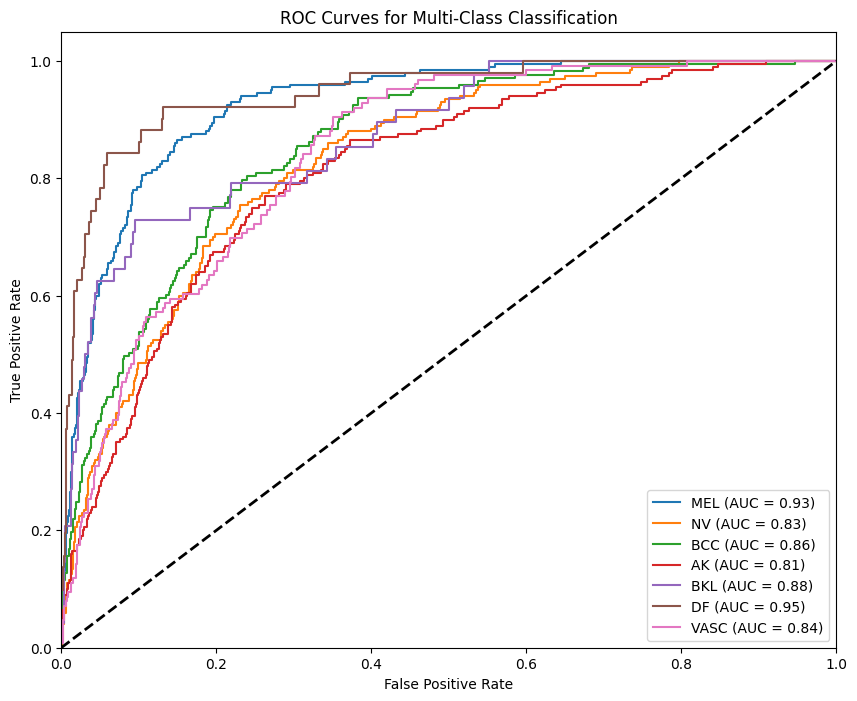

In [16]:
predicted_probs = np.array(res_pred).reshape(len(res_pred),8)
org_true = np.array(res_true)

true_labels = res_true
labell = {1:'MEL',2:'NV',3:'BCC',4:'AK',5:'BKL',6:'DF',7:'VASC',8:'SCC'}
n_classes = 8  # Replace with the number of classes in your problem

fpr = {}  # False Positive Rate
tpr = {}  # True Positive Rate
roc_auc = {}  # AUC

for i in range(1,n_classes):
    # Create binary labels for the current class (1 if it's the current class, 0 otherwise)
    y_true_ = np.array([1 if y == i else 0 for y in true_labels])

    # Get the predicted probabilities for the current class
    y_score = predicted_probs[:,i]
    # print(y_true_)
    # Calculate ROC curve and AUC for the current class
    fpr[i], tpr[i], _ = roc_curve(y_true_, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))

for i in range(1,n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{labell[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc='best')
plt.show()
